<br><font color='green'>
## ch.1 Libraries, Read data

*Load Libraries*

In [1]:
# basic 

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)
from itertools import combinations

# plot

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# models
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from vecstack import StackingTransformer
from vecstack import stacking

*Read Transaction Data*

In [2]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv')
IDtest = df_test.cust_id.unique()

Simple data proprecessing

In [3]:
df = pd.concat([df_train, df_test])

## 전체 train_test와 train에 월, 일, 요일, 계절, (월초, 월중, 월말) 칼럼 추가 
df['month'] = df['tran_date'].agg(lambda x: pd.to_datetime(x).month)
df['season'] = df['month'].agg(lambda x: 'spring' if x in [3,4,5] else 'summer' if x in [6,7,8] else 'fall' if x in [9,10,11] else 'winter')
df['day'] = df['tran_date'].agg(lambda x: pd.to_datetime(x).day)
df['date'] = df['tran_date'].agg(lambda x: ('월', '화', '수', '목', '금', '토', '일')[pd.to_datetime(x).weekday()])
df['month_when'] = df['day'].agg(lambda x: '0to10' if x in list(range(1,11)) else '11to20' if x in list(range(11,21)) else '21to31')

tr = df.query('cust_id not in @IDtest')
tr2 = df.query('cust_id in @IDtest')
tr = pd.merge(tr, y_train, on='cust_id')
trs = [tr, tr2]

for i in trs:

    i['amount_range'] = pd.cut(i['amount'],
       bins=[-300000000,0, 99999, 199999, 299990, 399990, 499990, 699990,999990, 1999990, 4999990, 800000000 ],
      right = False,
      labels = ['환불금액', '10만원이하', '10만원이상 20만원미만', '20만원이상 30만원미만', '30만원이상 40만원미만', '40만원이상 50만원미만', '50만원이상 70만원미만', '70만원이상 100만원미만', '100만원이상 200만원미만', '200만원이상 500만원미만', '500만원이상'])

*파생변수를 저장할 빈 리스트를 만든다.*

In [4]:
features = [] # 개인과제에서 생성된 feature들 담음
features1 = [] # 마지막에 train 끼리 모아 저장
features2 = [] # 마지막에 test 끼리 모아 저장

<br><font color='green'>
## ch.2 Features

## 1차 생성 features

### 1. 가격적 관점

 만든 피쳐들
   - 년 총 구매금액에 따른 등급, 가격 선호도 
   - 총 구매액,구매건수,최대구매액, 평균 구매액
   - 환불금액, 환불건수, 내점 당 구매액, 구매건수

<font color = 'blue'> 년 총 구매금액에 따른 등급 (실제 롯데백화점 등급 기준 적용)

 - 롯데백화점 MVG 조건(2020년 기준)
         - 해당하지 않는 고객들은 silver로 설정 -> 10
         - 400만원 이상: Vip -> 20
         - 800만원 이상: Vip+ -> 30
         - 1800~2000만원이상: MVG-Ace  -> 40
         - 4000만원이상: MVG-Crown -> 50
         - 6000만원이상: MVG-Prestige -> 60
         - 1억이상: LENITH -> 70

In [5]:
# 나누는 함수 정의
def divide_class(x):
    if 4000000<= x < 8000000:
        return 200
    elif 8000000<= x < 18000000:
        return 300
    elif 18000000<= x <40000000:
        return 400
    elif 40000000<= x <60000000:
        return 500
    elif 60000000<= x <100000000:
        return 600
    elif x>= 100000000:
        return 700
    else:
        return 100

for i in trs:
    
    temp_amountdf = i.groupby('cust_id')['amount'].sum().reset_index()

    temp_amountdf['class'] = temp_amountdf['amount'].agg(divide_class)

    f = temp_amountdf[['cust_id', 'class']]

    features.append(f); f

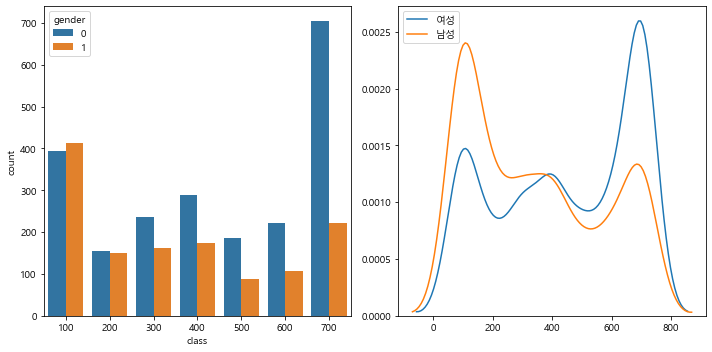

In [6]:
# vip고객을 구분하는 피쳐 생성 
temp_amountdf = tr.groupby('cust_id')['amount'].sum().reset_index()

temp_amountdf['class'] = temp_amountdf['amount'].agg(divide_class)

f = temp_amountdf[['cust_id', 'class']]

f['gender'] = y_train['gender']

figure, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(data=f, x='class', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0')['class'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['class'], ax=ax[1], label='남성')
plt.tight_layout()
plt.show()

<font color = 'blue'>

총구매액

In [7]:
for i in trs:
    f = i.groupby('cust_id')['amount'].agg([('total_amount',np.sum), ]).reset_index()

    bins2 =  [i*10000000 for i in range(235)]
    f['total_amount_range2'] = pd.cut(f.total_amount,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])

    f = f.fillna(0)
    f = f.drop('total_amount', axis=1)
    features.append(f); f

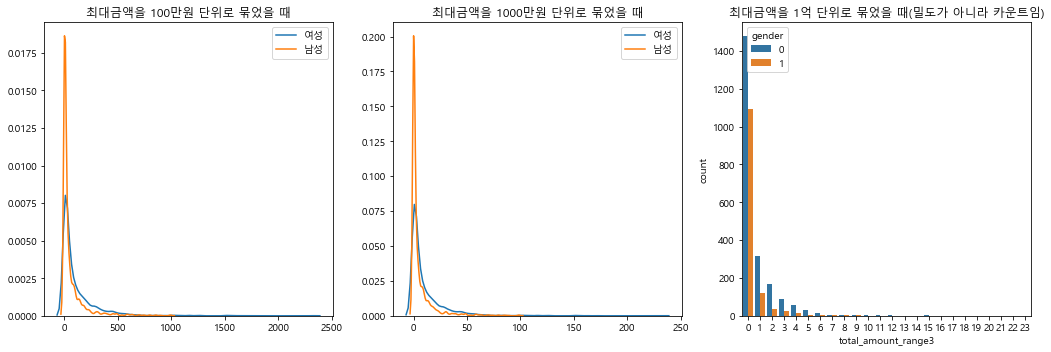

In [8]:
f = tr.groupby('cust_id')['amount'].agg([('total_amount',np.sum)]).reset_index()

f['gender'] = y_train['gender']

bins = [i*1000000 for i in range(2325)]
bins2 =  [i*10000000 for i in range(235)]
bins3 =  [i*100000000 for i in range(25)]

f['total_amount_range1'] = pd.cut(f.total_amount,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['total_amount_range2'] = pd.cut(f.total_amount,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f['total_amount_range3'] = pd.cut(f.total_amount,bins= bins3,labels=[i for i in range(0,len(bins3)-1)])

f = f.fillna(0)

figure, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['total_amount_range1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['total_amount_range1'], ax=ax[0], label='남성')
ax[0].set_title('최대금액을 100만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['total_amount_range2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['total_amount_range2'], ax=ax[1], label='남성')
ax[1].set_title('최대금액을 1000만원 단위로 묶었을 때')
sns.countplot(data=f, x='total_amount_range3', hue='gender', ax=ax[2])
ax[2].set_title('최대금액을 1억 단위로 묶었을 때(밀도가 아니라 카운트임)')

plt.tight_layout()
plt.show()

<font color = 'blue'>

구매건수

In [9]:
for i in trs:
    f = i.groupby('cust_id')['amount'].agg([('num_of_purchase', np.size), ]).reset_index()
    
    bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 300, 450, 600, 750, 900, 1050, 1200, 1350, 1500]
    f['purchase_count'] = pd.cut(f.num_of_purchase,bins= bins,labels=[i*10 for i in range(1,len(bins))])
    
    f = f.drop('num_of_purchase', axis=1)
    f = f.fillna(10)
    features.append(f); f  

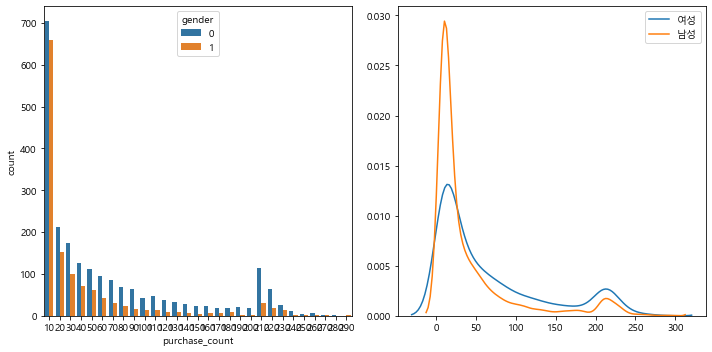

In [10]:
f = tr.groupby('cust_id')['amount'].agg([('num_of_purchase', np.size)]).reset_index()

f['gender'] = y_train['gender']

bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 300, 450, 600, 750, 900, 1050, 1200, 1350, 1500]

f['purchase_count'] = pd.cut(f.num_of_purchase,bins= bins,labels=[i*10 for i in range(1,len(bins))])

figure, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(data=f, x='purchase_count', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0')['purchase_count'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['purchase_count'], ax=ax[1], label='남성')
plt.tight_layout()
plt.show()

<font color = 'blue'>

평균구매액

In [11]:
for i in trs:
    f = i.groupby('cust_id')['amount'].agg([
        ('total_amount_avg', lambda x: np.round(np.mean(x))),]).reset_index()
    
    f.total_amount_avg = f.total_amount_avg.apply(lambda x: 0 if x<0 else x)

    bins = [i*100000 for i in range(1545)]
    f['total_amount_avg_range1'] = pd.cut(f.total_amount_avg,bins= bins,labels=[i for i in range(0,len(bins)-1)])

    
    f = f.drop('total_amount_avg', axis=1)
    f = f.fillna(0)
    features.append(f); f  

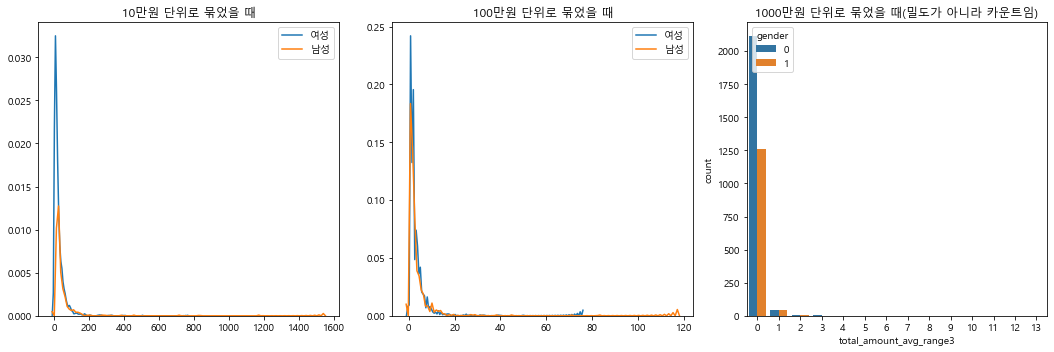

In [12]:
f = tr.groupby('cust_id')['amount'].agg([('total_amount_avg', lambda x: np.round(np.mean(x))),]).reset_index()

f.total_amount_avg = f.total_amount_avg.apply(lambda x: 0 if x<0 else x)

f['gender'] = y_train['gender']

bins = [i*100000 for i in range(1545)]
bins2 =  [i*1000000 for i in range(155)]
bins3 =  [i*10000000 for i in range(15)]

f['total_amount_avg_range1'] = pd.cut(f.total_amount_avg,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['total_amount_avg_range2'] = pd.cut(f.total_amount_avg,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f['total_amount_avg_range3'] = pd.cut(f.total_amount_avg, bins= bins3,labels=[i for i in range(0,len(bins3)-1)])


figure, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['total_amount_avg_range1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['total_amount_avg_range1'], ax=ax[0], label='남성')
ax[0].set_title('10만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['total_amount_avg_range2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['total_amount_avg_range2'], ax=ax[1], label='남성')
ax[1].set_title('100만원 단위로 묶었을 때')
sns.countplot(data=f, x='total_amount_avg_range3', hue='gender', ax=ax[2])
ax[2].set_title('1000만원 단위로 묶었을 때(밀도가 아니라 카운트임)')

plt.tight_layout()
plt.show()

<font color = 'blue'>

 최대구매액

In [13]:
for i in trs:
    f = i.groupby('cust_id')['amount'].agg([('max_amount', np.max),]).reset_index()
    

    bins2  = [i*10000000 for i in range(71)]
    f['max_amount_range2'] = pd.cut(f.max_amount, bins= bins2,labels=[i for i in range(1,len(bins2))])
    
    
    f = f.drop('max_amount', axis=1)
    f.max_amount_range2 = f['max_amount_range2'].fillna(1)    
    features.append(f); f  

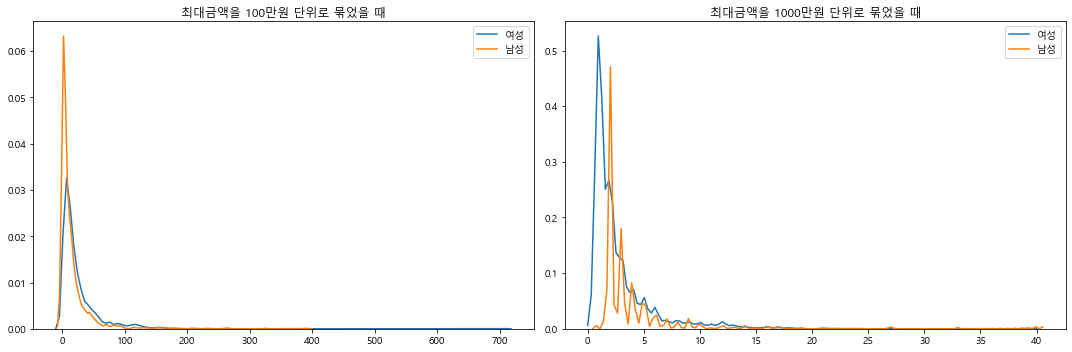

In [14]:
f = tr.groupby('cust_id')['amount'].agg([ ('max_amount', np.max),]).reset_index()

f['gender'] = y_train['gender']


bins = [i*1000000 for i in range(710)]
bins2  = [i*10000000 for i in range(71)]

f['max_amount_range1'] = pd.cut(f.max_amount, bins= bins,labels=[i for i in range(1,len(bins))])
f['max_amount_range2'] = pd.cut(f.max_amount, bins= bins2,labels=[i for i in range(1,len(bins2))])


figure, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['max_amount_range1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['max_amount_range1'], ax=ax[0], label='남성')
ax[0].set_title('최대금액을 100만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['max_amount_range2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['max_amount_range2'], ax=ax[1], label='남성')
ax[1].set_title('최대금액을 1000만원 단위로 묶었을 때')
plt.tight_layout()
plt.show()

<font color = 'blue'> 내점당 구매건수

In [15]:
# 내점 당 구매액 = 총구매액 / 내점일수
for i in trs:
    
    visits = i.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique()) # 내점일수
    
    f = (i.groupby('cust_id')['amount'].size() / visits).reset_index().rename(columns={0 : "per_visit_pur_num"})
    
    f.per_visit_pur_num = f.per_visit_pur_num.apply(lambda x: round(x))
    
    features.append(f); f

In [16]:
visits = tr.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique()) # 내점일수

f = (tr.groupby('cust_id')['amount'].size() / visits).reset_index().rename(columns={0 : "per_visit_pur_num"})

f.per_visit_pur_num = f.per_visit_pur_num.apply(lambda x: round(x))

f['gender'] = y_train['gender']

bins = [i for i in range(22)]
bins2 =  [i*2 for i in range(11)]

f['per_visit_pur_num1'] = pd.cut(f.per_visit_pur_num,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['per_visit_pur_num2'] = pd.cut(f.per_visit_pur_num,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])

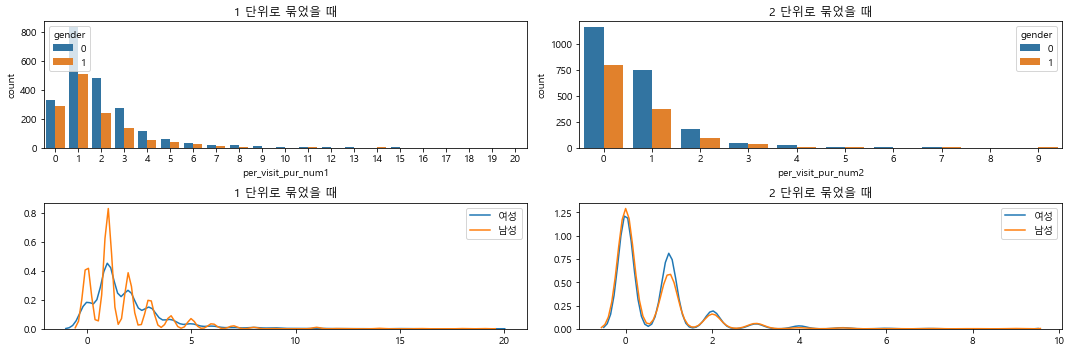

In [17]:
figure, ax = plt.subplots(2, 2, figsize=(15, 5))
sns.countplot(data=f, x='per_visit_pur_num1', hue='gender', ax=ax[0,0])
ax[0,0].set_title('1 단위로 묶었을 때')
sns.countplot(data=f, x='per_visit_pur_num2', hue='gender', ax=ax[0,1])
ax[0,1].set_title('2 단위로 묶었을 때')

sns.kdeplot(f.query('gender==0')['per_visit_pur_num1'], ax=ax[1,0], label='여성')
sns.kdeplot(f.query('gender==1')['per_visit_pur_num1'], ax=ax[1,0], label='남성')
ax[1,0].set_title('1 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['per_visit_pur_num2'], ax=ax[1,1], label='여성')
sns.kdeplot(f.query('gender==1')['per_visit_pur_num2'], ax=ax[1,1], label='남성')
ax[1,1].set_title('2 단위로 묶었을 때')

plt.tight_layout()
plt.show()


## ────────────────────────────────────────────────────────
### 2. 시간적 관점

 만든 피쳐들
   - 내점일수, 구매주기
   - 선호방문계절, 계절별 구매비율(s:3to5, s:6to8, f:9to11, w:12to2)
   - 선호방문월, 방문비율, 구매비율, 구매건수
   - 월초, 월중, 월말 선호 방문때, 방문비율, 구매비율, 구매건수
   - 최근 3개월, 6개월, 12개월 구매금액, 구매건수
   - 선호방문요일, 방문비율, 구매비율, 구매건수
   - 주말방문비율, 고객별 주말구매건수

<font color = 'blue'> 내점일수

In [18]:
for i in trs:
    f = i.groupby('cust_id')['tran_date'].agg([
        ('total_visit',lambda x: x.str[:10].nunique())]).reset_index()
    
    bins2 =  [i*2 for i in range(143)]
    f['total_visit2'] = pd.cut(f.total_visit,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
    
    f = f.drop('total_visit', axis=1)
    f = f.fillna(0)
    features.append(f); f  

In [19]:
f = tr.groupby('cust_id')['tran_date'].agg([('total_visit',lambda x: x.str[:10].nunique()),]).reset_index()

f['gender'] = y_train['gender']

bins = [i for i in range(285)]
bins2 =  [i*2 for i in range(143)]

f['total_visit1'] = pd.cut(f.total_visit,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['total_visit2'] = pd.cut(f.total_visit,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])

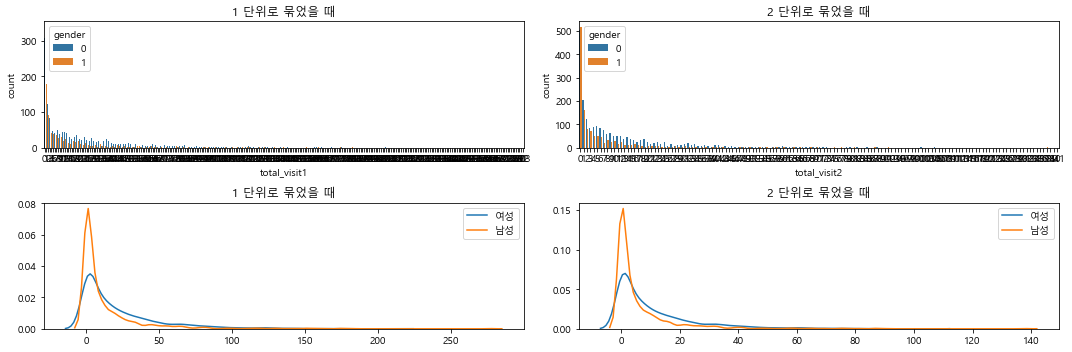

In [20]:
figure, ax = plt.subplots(2, 2, figsize=(15, 5))
sns.countplot(data=f, x='total_visit1', hue='gender', ax=ax[0,0])
ax[0,0].set_title('1 단위로 묶었을 때')
sns.countplot(data=f, x='total_visit2', hue='gender', ax=ax[0,1])
ax[0,1].set_title('2 단위로 묶었을 때')

sns.kdeplot(f.query('gender==0')['total_visit1'], ax=ax[1,0], label='여성')
sns.kdeplot(f.query('gender==1')['total_visit1'], ax=ax[1,0], label='남성')
ax[1,0].set_title('1 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['total_visit2'], ax=ax[1,1], label='여성')
sns.kdeplot(f.query('gender==1')['total_visit2'], ax=ax[1,1], label='남성')
ax[1,1].set_title('2 단위로 묶었을 때')

plt.tight_layout()
plt.show()

<font color = 'blue'>
    구매주기

In [21]:
for i in trs:
    f = i.groupby('cust_id')['tran_date'].agg([('buying_cycle', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.str[:10].nunique()))]).reset_index()

    bins2 =  [i*2 for i in range(78)]
    f['buying_cycle2'] = pd.cut(f.buying_cycle,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])    
    
    f = f.drop('buying_cycle', axis=1) 
    f.buying_cycle2 = f['buying_cycle2'].fillna(0) 
    features.append(f); f  

In [22]:
f = tr.groupby('cust_id')['tran_date'].agg([('buying_cycle', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.str[:10].nunique()))]).reset_index()

f['gender'] = y_train['gender']

bins = [i for i in range(166)]
bins2 =  [i*2 for i in range(78)]

f['buying_cycle1'] = pd.cut(f.buying_cycle,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['buying_cycle2'] = pd.cut(f.buying_cycle,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])

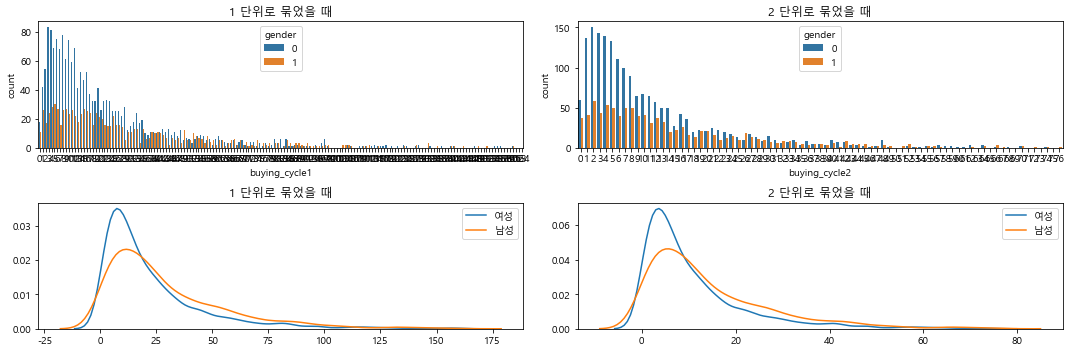

In [23]:
figure, ax = plt.subplots(2, 2, figsize=(15, 5))
sns.countplot(data=f, x='buying_cycle1', hue='gender', ax=ax[0,0])
ax[0,0].set_title('1 단위로 묶었을 때')
sns.countplot(data=f, x='buying_cycle2', hue='gender', ax=ax[0,1])
ax[0,1].set_title('2 단위로 묶었을 때')

sns.kdeplot(f.query('gender==0')['buying_cycle1'], ax=ax[1,0], label='여성')
sns.kdeplot(f.query('gender==1')['buying_cycle1'], ax=ax[1,0], label='남성')
ax[1,0].set_title('1 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['buying_cycle2'], ax=ax[1,1], label='여성')
sns.kdeplot(f.query('gender==1')['buying_cycle2'], ax=ax[1,1], label='남성')
ax[1,1].set_title('2 단위로 묶었을 때')

plt.tight_layout()
plt.show()

<font color = 'blue'> 선호방문계절

In [24]:
## 고객별 선호방문계절
for i in trs:
    f = i.groupby('cust_id')['season'].agg([
        ('perfer_season', lambda x: x.value_counts().index[0])
    ]).reset_index()

## spring은 0, summer는 1, fall은 2, winter는 3으로 바꿔주기
    f.perfer_season = f.perfer_season.map({'spring': 0, 'summer':1, 'fall':2, 'winter':3})

    features.append(f); f

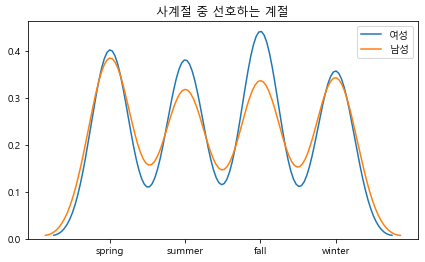

In [25]:
## 고객별 선호방문계절
f = tr.groupby('cust_id')['season'].agg([('prefer_season', lambda x: x.value_counts().index[0])]).reset_index()

## spring은 0, summer는 1, fall은 2, winter는 3으로 바꿔주기
f.prefer_season = f.prefer_season.map({'spring': 0, 'summer':1, 'fall':2, 'winter':3})

f['gender'] = y_train['gender']

plt.figure(figsize=(7,4))
sns.kdeplot(f.query('gender==0').prefer_season, label = '여성')
sns.kdeplot(f.query('gender==1').prefer_season, label = '남성')
plt.xticks([0,1,2,3],['spring','summer','fall','winter'])
plt.title('사계절 중 선호하는 계절')
plt.show()

<font color = 'blue'> 계절별 구매비율(s:3to5, s:6to8, f:9to11, w:12to2)

In [26]:
for i in trs:
    
    f = i.groupby('cust_id')['tran_date'].agg([
        ('spring_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([3,4,5]))),
        ('summer_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([6,7,8]))),
        ('fall_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([9,10,11]))),
        ('winter_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([1,2,12])))
    ]).reset_index()
    
    features.append(f); f

In [27]:
f = tr.groupby('cust_id')['tran_date'].agg([
    ('spring_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([3,4,5]))),
    ('summer_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([6,7,8]))),
    ('fall_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([9,10,11]))),
    ('winter_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([1,2,12])))
]).reset_index()

f['gender'] = y_train['gender']

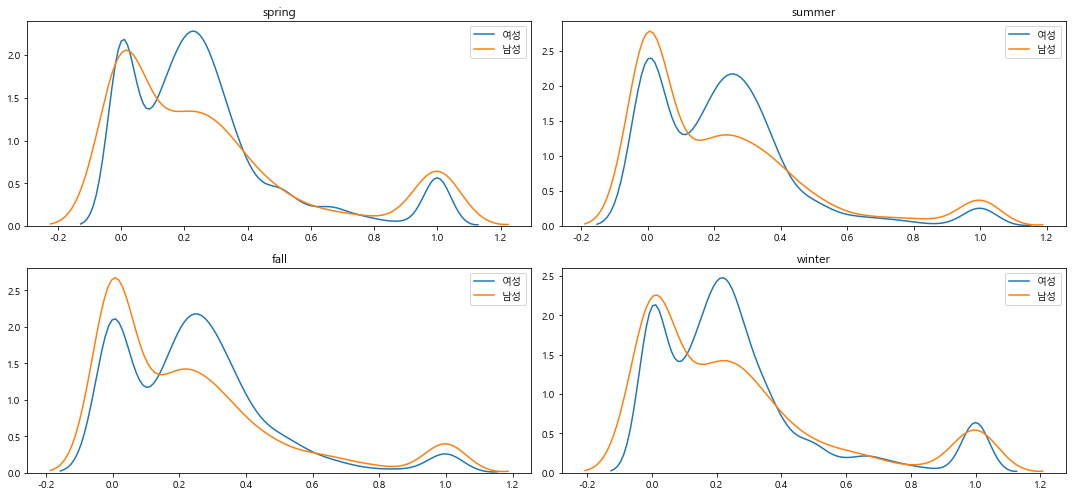

In [28]:
figure, ax = plt.subplots(2, 2, figsize=(15, 7))
sns.kdeplot(f.query('gender==0').spring_pur_ratio, label = '여성', ax=ax[0,0])
sns.kdeplot(f.query('gender==1').spring_pur_ratio, label = '남성', ax=ax[0,0])
ax[0,0].set_title('spring')
ax[0,1].set_title('summer')
sns.kdeplot(f.query('gender==0').summer_pur_ratio, label = '여성', ax=ax[0,1])
sns.kdeplot(f.query('gender==1').summer_pur_ratio, label = '남성', ax=ax[0,1])
ax[1,0].set_title('fall')
sns.kdeplot(f.query('gender==0').fall_pur_ratio, label = '여성', ax=ax[1,0])
sns.kdeplot(f.query('gender==1').fall_pur_ratio, label = '남성', ax=ax[1,0])
ax[1,1].set_title('winter')
sns.kdeplot(f.query('gender==0').winter_pur_ratio, label = '여성', ax=ax[1,1])
sns.kdeplot(f.query('gender==1').winter_pur_ratio, label = '남성', ax=ax[1,1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 선호방문월

In [29]:
## 선호방문월

for i in trs:
    
    f = i.groupby('cust_id')['month'].agg([
        ('prefer_month', lambda x: x.value_counts(1).index[0])
    ]).reset_index()

    features.append(f); f

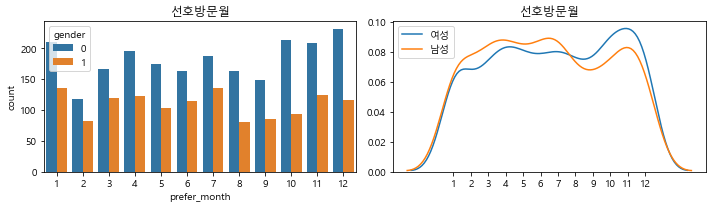

In [30]:
f = tr.groupby('cust_id')['month'].agg([('prefer_month', lambda x: x.value_counts(1).index[0])]).reset_index()

f['gender'] = y_train['gender']

figure, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.countplot(data=f, x='prefer_month', hue='gender', ax=ax[0])
ax[0].set_title('선호방문월')

sns.kdeplot(f.query('gender==0').prefer_month, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').prefer_month, label = '남성', ax=ax[1])
plt.xticks([i for i in range(1,13)])
plt.title('선호방문월')

plt.tight_layout()
plt.show()

<font color = 'blue'> 구매비율
    - 12달 중 1월, 2월 그리고 9월을 피쳐로 채택

In [31]:
## 월별 구매비율
for i in trs:
    
    # 고객별 구매금액 총합
    total_amount =  i.groupby('cust_id')['amount'].sum()
    
    # 고객별 월별 구매금액
    temp_monthpivot = pd.pivot_table(i, index='cust_id', columns='month', values='amount', aggfunc=sum, fill_value=0)

    # 칼럼명 변경화
    oldname = temp_monthpivot.columns.tolist()
    newname = [str(i)+'_month_amount' for i in oldname]
    temp_monthpivot = temp_monthpivot.rename(columns=dict(zip(oldname, newname)))

    # 고객별 월별 구매금액비율
    for i in range(len(temp_monthpivot.columns)):
    
        temp_monthpivot.iloc[:,i] = temp_monthpivot.iloc[:,i] / total_amount
    
    f = temp_monthpivot.reset_index()
    f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)
    f = f[['cust_id', '1_month_amount', '2_month_amount','9_month_amount']]
    features.append(f); f

In [32]:
# 고객별 구매금액 총합
total_amount =  tr.groupby('cust_id')['amount'].sum()
    
# 고객별 월별 구매금액
temp_monthpivot = pd.pivot_table(tr, index='cust_id', columns='month', values='amount', aggfunc=sum, fill_value=0)

# 고객별 월별 구매금액비율
for i in range(len(temp_monthpivot.columns)):
    
    temp_monthpivot.iloc[:,i] = temp_monthpivot.iloc[:,i] / total_amount
    
f = temp_monthpivot.reset_index()
f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)

f['gender'] = y_train['gender']


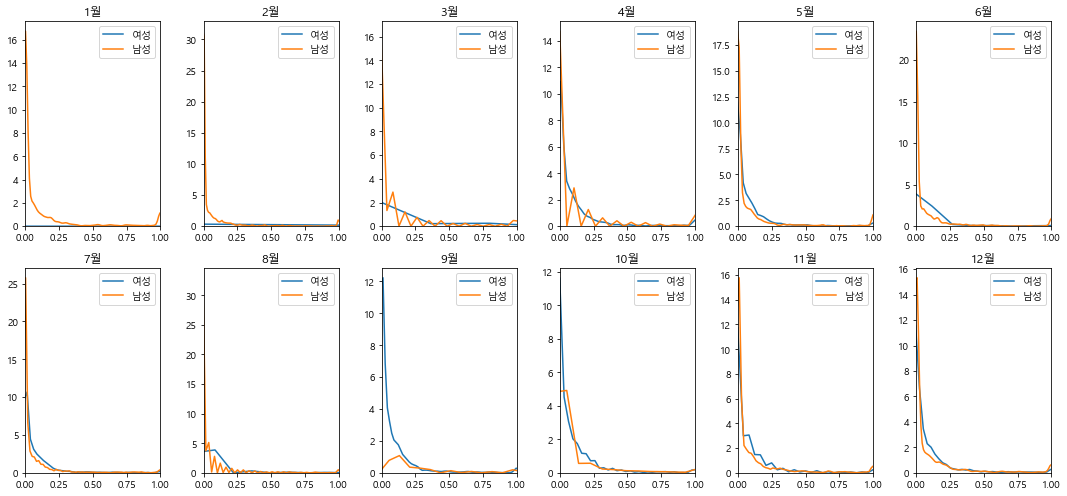

In [33]:
figure, ax = plt.subplots(2, 6, figsize=(15, 7))

for month in range(1,7):
    sns.kdeplot(f.query('gender==0')[month], label = '여성', ax=ax[0,month-1]) 
    sns.kdeplot(f.query('gender==1')[month], label = '남성', ax=ax[0,month-1])
    ax[0,month-1].set_xlim(0,1)
    ax[0,month-1].set_title(f'{month}월')

temp = 0
for month in range(7,13):
    
    sns.kdeplot(f.query('gender==0')[month], label = '여성', ax=ax[1,temp]) 
    sns.kdeplot(f.query('gender==1')[month], label = '남성', ax=ax[1,temp])
    ax[1,temp].set_xlim(0,1)
    ax[1,temp].set_title(f'{month}월')
    temp += 1

plt.tight_layout()
plt.show()

<font color = 'blue'>  월초, 월중, 월말 방문비율


In [34]:
## 고객별 월초, 월중, 월말 방문비율

for i in trs:
    
    # 총 방문일수
    total_visits = i.groupby('cust_id')['tran_date'].nunique()
        
    # 고객별 월초, 월중, 월말 방문일수
    temp_monthwhenpivot = pd.pivot_table(i, index='cust_id', columns='month_when', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

    # 칼럼명 변경화
    oldname = temp_monthwhenpivot.columns.tolist()
    newname = [str(i)+'_visits' for i in oldname]
    temp_monthwhenpivot = temp_monthwhenpivot.rename(columns=dict(zip(oldname, newname)))

    # 고객별 월초, 월중, 월말 방문비율

    for i in range(len(temp_monthwhenpivot.columns)):
    
            temp_monthwhenpivot.iloc[:,i] = temp_monthwhenpivot.iloc[:,i] / total_visits
    
    f = temp_monthwhenpivot.reset_index()

    features.append(f); f

In [35]:
# 총 방문일수
total_visits = tr.groupby('cust_id')['tran_date'].nunique()
        
# 고객별 월초, 월중, 월말 방문일수
temp_monthwhenpivot = pd.pivot_table(tr, index='cust_id', columns='month_when', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

# 고객별 월초, 월중, 월말 방문비율

for i in range(len(temp_monthwhenpivot.columns)):
    
        temp_monthwhenpivot.iloc[:,i] = temp_monthwhenpivot.iloc[:,i] / total_visits
    
f = temp_monthwhenpivot.reset_index()

f['gender'] = y_train['gender']


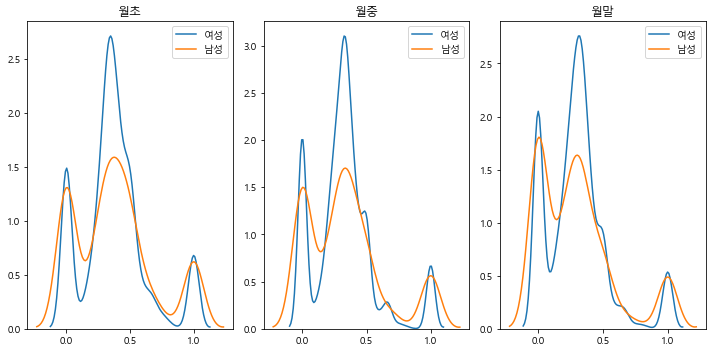

In [36]:
figure, ax = plt.subplots(1, 3, figsize=(10, 5))
sns.kdeplot(f.query('gender==0')['0to10'], label = '여성', ax=ax[0]) 
sns.kdeplot(f.query('gender==1')['0to10'], label = '남성', ax=ax[0])
ax[0].set_title('월초')
sns.kdeplot(f.query('gender==0')['11to20'], label = '여성', ax=ax[1]) 
sns.kdeplot(f.query('gender==1')['11to20'], label = '남성', ax=ax[1])
ax[1].set_title('월중')
sns.kdeplot(f.query('gender==0')['21to31'], label = '여성', ax=ax[2]) 
sns.kdeplot(f.query('gender==1')['21to31'], label = '남성', ax=ax[2])
ax[2].set_title('월말')

plt.tight_layout()
plt.show()

<font color = 'blue'>  월초, 월중, 월말 구매비율


In [37]:
##고객별 월초, 월중, 월말 구매비율

for i in trs:
    
    # 고객별 구매금액 총합
    total_amount =  i.groupby('cust_id')['amount'].sum()
    
    # 고객별 월초, 월중, 월말별 구매금액
    temp_monthwhenpivot = pd.pivot_table(i, index='cust_id', columns='month_when', values='amount', aggfunc=sum, fill_value=0)

    # 칼럼명 변경화
    oldname = temp_monthwhenpivot.columns.tolist()
    newname = [str(i)+'_amount' for i in oldname]
    temp_monthwhenpivot = temp_monthwhenpivot.rename(columns=dict(zip(oldname, newname)))

    # 고객별 월초, 월중, 월말별 구매금액비율
    for i in range(len(temp_monthwhenpivot.columns)):
    
        temp_monthwhenpivot.iloc[:,i] = temp_monthwhenpivot.iloc[:,i] / total_amount
    
    f = temp_monthwhenpivot.reset_index()
    f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)

    features.append(f); f

In [38]:
# 고객별 구매금액 총합
total_amount = tr.groupby('cust_id')['amount'].sum()
    
# 고객별 월초, 월중, 월말별 구매금액
temp_monthwhenpivot = pd.pivot_table(tr, index='cust_id', columns='month_when', values='amount', aggfunc=sum, fill_value=0)

# 고객별 월초, 월중, 월말별 구매금액비율
for i in range(len(temp_monthwhenpivot.columns)):
    
    temp_monthwhenpivot.iloc[:,i] = temp_monthwhenpivot.iloc[:,i] / total_amount
    
f = temp_monthwhenpivot.reset_index()
f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)

f['gender'] = y_train['gender']

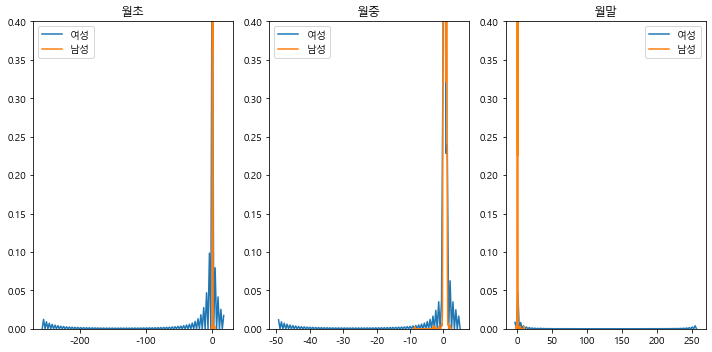

In [39]:
figure, ax = plt.subplots(1, 3, figsize=(10, 5))
sns.kdeplot(f.query('gender==0')['0to10'], label = '여성', ax=ax[0]) 
sns.kdeplot(f.query('gender==1')['0to10'], label = '남성', ax=ax[0])
ax[0].set_title('월초')
ax[0].set_ylim(0,0.4)
sns.kdeplot(f.query('gender==0')['11to20'], label = '여성', ax=ax[1]) 
sns.kdeplot(f.query('gender==1')['11to20'], label = '남성', ax=ax[1])
ax[1].set_title('월중')
ax[1].set_ylim(0,0.4)
sns.kdeplot(f.query('gender==0')['21to31'], label = '여성', ax=ax[2]) 
sns.kdeplot(f.query('gender==1')['21to31'], label = '남성', ax=ax[2])
ax[2].set_title('월말')
ax[2].set_ylim(0,0.4)
plt.tight_layout()
plt.show()

<font color = 'blue'>  월초, 월중, 월말 구매건수


In [40]:
## 고객별 월초, 월중, 월말 구매건수

for i in trs:
    
    temp_monthwhenpivot = pd.pivot_table(i, index='cust_id', columns='month_when', values='amount', aggfunc=np.size, fill_value=0)
    
    
    
    # 칼럼명 변경화
    oldname = temp_monthwhenpivot.columns.tolist()
    newname = [str(i)+'_buy' for i in oldname]
    temp_monthwhenpivot = temp_monthwhenpivot.rename(columns=dict(zip(oldname, newname)))

    f = temp_monthwhenpivot.reset_index()
    
    bins = [i*10 for i in range(57)]
    bins2 = [i*10 for i in range(65)]
    bins3 = [i*10 for i in range(67)]
    labels = [i for i in range(len(bins)-1)]
    labels2 = [i for i in range(len(bins2)-1)]
    labels3 = [i for i in range(len(bins3)-1)]
    f['0to10_10unit'] = pd.cut(f['0to10_buy'], bins=bins, labels = labels)
    f['11to20_20unit'] = pd.cut(f['11to20_buy'], bins=bins2, labels = labels2)
    f['21to31_30unit'] = pd.cut(f['21to31_buy'], bins=bins3, labels = labels3)
    f = f.drop('0to10_buy', axis=1) 
    f = f.drop('11to20_buy', axis=1) 
    f = f.drop('21to31_buy', axis=1) 
    f = f.fillna(0)

    features.append(f); f

In [41]:
temp_monthwhenpivot = pd.pivot_table(tr, index='cust_id', columns='month_when', values='amount', aggfunc=np.size, fill_value=0)

f = temp_monthwhenpivot.reset_index()

f['gender'] = y_train['gender']

In [42]:
bins = [i*10 for i in range(57)]
bins2 = [i*10 for i in range(65)]
bins3 = [i*10 for i in range(67)]
labels = [i for i in range(len(bins)-1)]
labels2 = [i for i in range(len(bins2)-1)]
labels3 = [i for i in range(len(bins3)-1)]
f['0to10_10unit'] = pd.cut(f['0to10'], bins=bins, labels = labels)
f['11to20_20unit'] = pd.cut(f['11to20'], bins=bins2, labels = labels2)
f['21to31_30unit'] = pd.cut(f['21to31'], bins=bins3, labels = labels3)

f = f.fillna(0)

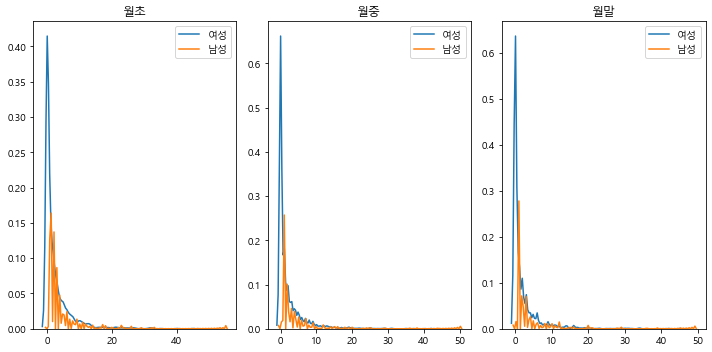

In [43]:
figure, ax = plt.subplots(1, 3, figsize=(10, 5)) 
sns.kdeplot(f.query('gender==0')['0to10_10unit'], label = '여성', ax=ax[0]) 
sns.kdeplot(f.query('gender==1')['0to10_10unit'], label = '남성', ax=ax[0])
ax[0].set_title('월초')
sns.kdeplot(f.query('gender==0')['11to20_20unit'], label = '여성', ax=ax[1]) 
sns.kdeplot(f.query('gender==1')['11to20_20unit'], label = '남성', ax=ax[1])
ax[1].set_title('월중')
sns.kdeplot(f.query('gender==0')['21to31_30unit'], label = '여성', ax=ax[2]) 
sns.kdeplot(f.query('gender==1')['21to31_30unit'], label = '남성', ax=ax[2])
ax[2].set_title('월말')

plt.tight_layout()
plt.show()

<font color = 'blue'> 선호방문요일


In [44]:
## 선호방문요일

for i in trs:
    
    f = i.groupby('cust_id')['date'].agg([
        ('prefer_date', lambda x: x.value_counts().index[0])
    ]).reset_index()

    # 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
    f.prefer_date = f.prefer_date.map({'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})


    features.append(f); f

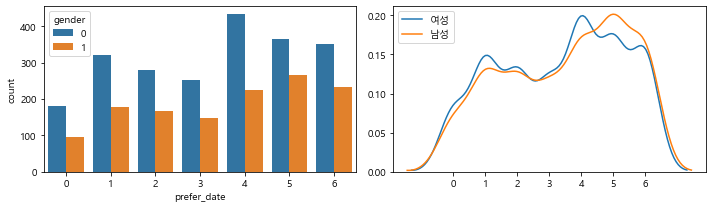

In [45]:
f = tr.groupby('cust_id')['date'].agg([('prefer_date', lambda x: x.value_counts().index[0])]).reset_index()

# 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
f.prefer_date = f.prefer_date.map({'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})

f['gender'] = y_train['gender']

figure, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.countplot(data=f, x='prefer_date', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').prefer_date, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').prefer_date, label = '남성', ax=ax[1])
plt.xticks([i for i in range(7)])

plt.tight_layout()
plt.show()

<font color = 'blue'> 방문비율


In [46]:
## 요일별 방문비율

for i in trs:
    
    # 총 방문일수
    total_visits = i.groupby('cust_id')['tran_date'].nunique()

    # 고객별 요일별 방문일수
    temp_datepivot = pd.pivot_table(i, index='cust_id', columns='date', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

    # 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
    temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})
    
    # 칼럼명 변경화
    oldname = temp_datepivot.columns.tolist()
    newname = [str(i)+'_visits' for i in oldname]
    temp_datepivot = temp_datepivot.rename(columns=dict(zip(oldname, newname)))
    
    # 고객별 요일별 방문비율
    
    for i in range(len(temp_datepivot.columns)):
        
            temp_datepivot.iloc[:,i] = temp_datepivot.iloc[:,i] / total_visits
        
    f = temp_datepivot.reset_index()
    f = f[['cust_id','0_visits','1_visits','2_visits','3_visits','4_visits', '5_visits']]

    features.append(f); f

In [47]:
 # 총 방문일수
total_visits = tr.groupby('cust_id')['tran_date'].nunique()

# 고객별 요일별 방문일수
temp_datepivot = pd.pivot_table(tr, index='cust_id', columns='date', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

# 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})
    
# 고객별 요일별 방문비율
for i in range(len(temp_datepivot.columns)):
        
    temp_datepivot.iloc[:,i] = temp_datepivot.iloc[:,i] / total_visits
        
f = temp_datepivot.reset_index()
f['gender'] = y_train['gender']

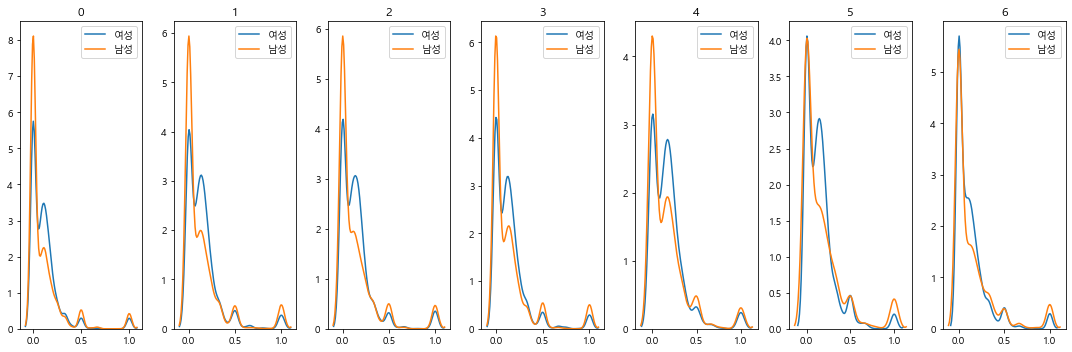

In [48]:
figure, ax = plt.subplots(1, 7, figsize=(15, 5))

for date in range(7):
    sns.kdeplot(f.query('gender==0')[date], label = '여성', ax=ax[date])
    sns.kdeplot(f.query('gender==1')[date], label = '남성', ax=ax[date])
    ax[date].set_title(f'{date}')

plt.tight_layout()
plt.show()

<font color = 'blue'> 구매비율


In [49]:
## 고객별 요일별 구매비율

for i in trs:
    
    # 고객별 구매금액 총합
    total_amount =  i.groupby('cust_id')['amount'].sum()
    # 고객별 요일별구매금액
    temp_datepivot = pd.pivot_table(i, index='cust_id', columns='date', values='amount', aggfunc=sum, fill_value=0)
    
    # 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
    temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})
    
    # 칼럼명 변경화
    oldname = temp_datepivot.columns.tolist()
    newname = [str(i)+'_amount' for i in oldname]
    temp_datepivot = temp_datepivot.rename(columns=dict(zip(oldname, newname)))
    
    # 고객별 요일별 구매금액비율
    for i in range(len(temp_datepivot.columns)):
        
        temp_datepivot.iloc[:,i] = temp_datepivot.iloc[:,i] / total_amount
        
    f = temp_datepivot.reset_index()
    f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)
    features.append(f); f

In [50]:
# 고객별 구매금액 총합
total_amount =  tr.groupby('cust_id')['amount'].sum()
# 고객별 요일별구매금액
temp_datepivot = pd.pivot_table(tr, index='cust_id', columns='date', values='amount', aggfunc=sum, fill_value=0)
    
# 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})
    
# 고객별 요일별 구매금액비율
for i in range(len(temp_datepivot.columns)):
        
    temp_datepivot.iloc[:,i] = temp_datepivot.iloc[:,i] / total_amount
        
f = temp_datepivot.reset_index()
f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)
f['gender'] = y_train['gender']

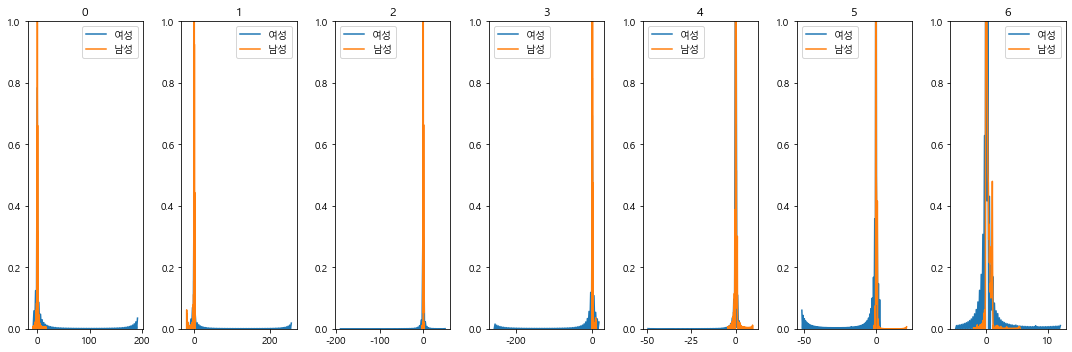

In [51]:
figure, ax = plt.subplots(1, 7, figsize=(15, 5))

for date in range(7):
    sns.kdeplot(f.query('gender==0')[date], label = '여성', ax=ax[date])
    sns.kdeplot(f.query('gender==1')[date], label = '남성', ax=ax[date])
    ax[date].set_title(f'{date}')
    ax[date].set_ylim(0,1)

plt.tight_layout()
plt.show()

<font color = 'blue'> 구매건수


In [52]:
## 고객별 요일별 구매건수

for i in trs:
    
    temp_datepivot = pd.pivot_table(i, index='cust_id', columns='date', values='amount', aggfunc=np.size, fill_value=0)
    
    # 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
    temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})

    ## 칼럼명 변경화
    oldname = temp_datepivot.columns.tolist()
    newname = [str(i)+'_buy' for i in oldname]
    temp_datepivot = temp_datepivot.rename(columns=dict(zip(oldname, newname)))
    
    f = temp_datepivot.reset_index()

    features.append(f); f

In [53]:
temp_datepivot = pd.pivot_table(tr, index='cust_id', columns='date', values='amount', aggfunc=np.size, fill_value=0)
    
# 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})

f = temp_datepivot.reset_index()

f['gender'] = y_train['gender']

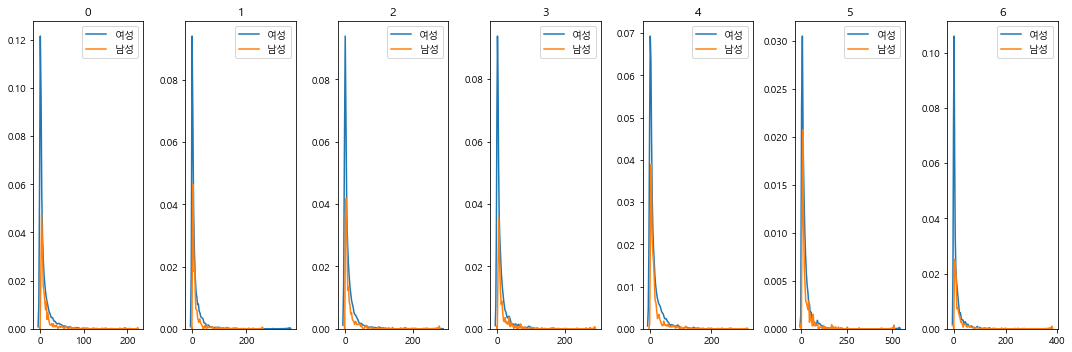

In [54]:
figure, ax = plt.subplots(1, 7, figsize=(15, 5))

for date in range(7):
    sns.kdeplot(f.query('gender==0')[date], label = '여성', ax=ax[date])
    sns.kdeplot(f.query('gender==1')[date], label = '남성', ax=ax[date])
    ax[date].set_title(f'{date}')
plt.tight_layout()
plt.show()

<font color = 'blue'> 주말방문비율

In [55]:
## 주말방문비율

for i in trs:
    
    f = i.groupby('cust_id')['tran_date'].agg([
        ('weekend_visit_ratio', lambda x: np.mean(pd.to_datetime(x).dt.dayofweek>4))
    ]).reset_index()
    features.append(f); f

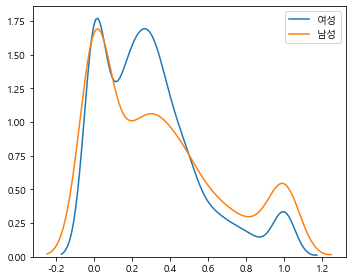

In [56]:
f = tr.groupby('cust_id')['tran_date'].agg([('weekend_visit_ratio', lambda x: np.mean(pd.to_datetime(x).dt.dayofweek>4))]).reset_index()

f['gender'] = y_train['gender']

plt.figure(figsize= (5,4))
sns.kdeplot(f.query('gender==0').weekend_visit_ratio, label = '여성')
sns.kdeplot(f.query('gender==1').weekend_visit_ratio, label = '남성')

plt.tight_layout()
plt.show()

<font color = 'blue'> 고객별 주말구매건수

In [57]:
## 주말 구매건수

for i in trs:
    
    temp_datepivot = pd.pivot_table(i, index='cust_id', columns='date', values='amount', aggfunc=np.size, fill_value=0)

    f = temp_datepivot[['토','일']].sum(axis=1).reset_index().rename(columns={0:'weekend_buy'})
    
    
    bins2 =  [i*10 for i in range(63)]
    f['weekend_buy2'] = pd.cut(f.weekend_buy,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
    f.weekend_buy2 = f.weekend_buy2.fillna(0)
    f = f.drop('weekend_buy', axis=1)
    features.append(f); f

In [58]:
temp_datepivot = pd.pivot_table(tr, index='cust_id', columns='date', values='amount', aggfunc=np.size, fill_value=0)

f = temp_datepivot[['토','일']].sum(axis=1).reset_index().rename(columns={0:'weekend_buy'})

f['gender'] = y_train['gender']

In [59]:
bins2 =  [i*10 for i in range(63)]
f['weekend_buy2'] = pd.cut(f.weekend_buy,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f.weekend_buy2 = f.weekend_buy2.fillna(0)

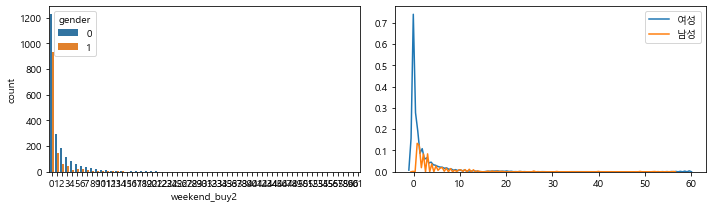

In [60]:
figure, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.countplot(data=f, x='weekend_buy2', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').weekend_buy2, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').weekend_buy2, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

## ────────────────────────────────────────────────────────

### 3. 장소적 관점

만든 피쳐들
   - 주구매지점
   - 방문 지점의 수
   - 많이 방문한 지점들 best-12 순위별 구매금액비율, 구매건수

<font color = 'blue'>  방문 지점의 수

In [61]:
## 고객별 방문 지점의 수

for i in trs:

    f = i.groupby('cust_id')['store_nm'].nunique().reset_index().rename(columns={'store_nm':'stores_count'})

    features.append(f); f

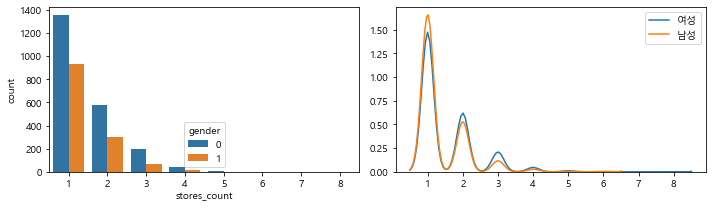

In [62]:
f = tr.groupby('cust_id')['store_nm'].nunique().reset_index().rename(columns={'store_nm':'stores_count'})

f['gender'] = y_train['gender']


figure, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.countplot(data=f, x='stores_count', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').stores_count, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').stores_count, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 많이 방문한 지점들 best-12 순위별 방문비율
    - top-12가 전체 24개의 점포중 91% 데이터를 차지한다.

In [63]:
## 전체의 90프로를 넘게 차지하는 12개의 점포 데이터

for i in trs:

    print(i.store_nm.value_counts()[:12].sum() / i.store_nm.value_counts().sum())

0.9145704384407165
0.9261790924320424


In [64]:
top12store_all = []

for i in trs:
    
    ## top-12에 해당하는 지점들
    
    top12store = i.store_nm.value_counts()[:12].index.tolist()
    
    top12store_all.append(top12store)
    
top12store_train = top12store_all[0]; print(top12store_train)
top12store_test = top12store_all[1]; print(top12store_test)
print()
intersection_store = list(set(top12store_train).intersection(top12store_test)); print(intersection_store)
print('겹치는 지점 수: ', len(intersection_store))

['본  점', '분당점', '잠실점', '부산본점', '일산점', '노원점', '광주점', '영등포점', '강남점', '부평점', '청량리점', '대전점']
['본  점', '분당점', '잠실점', '일산점', '강남점', '부산본점', '청량리점', '광주점', '영등포점', '미아점', '노원점', '부평점']

['부산본점', '강남점', '영등포점', '부평점', '청량리점', '노원점', '잠실점', '분당점', '본  점', '광주점', '일산점']
겹치는 지점 수:  11


In [65]:
## intersection_store 방문비율

for i in trs:
    ## nan값 방지
    if len(i) == 232004:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500)})
    else:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500,5982)})

    # 고객별 전체방문일수
    total_visits = i.groupby('cust_id')['tran_date'].nunique()
    # 고객별 점포별 방문일수
    temp_storepivot = pd.pivot_table(i.query('store_nm in @intersection_store'), index='cust_id', columns='store_nm', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

    
    # 칼럼명 영문화
    engname = temp_storepivot.columns.tolist()
    newname = [str(i*10)+'_visits' for i in range(len(engname))]
    temp_storepivot = temp_storepivot.rename(columns=dict(zip(engname, newname)))

    # 고객별 점포별 방문비율
    for i in range(len(temp_storepivot.columns)):
    
        temp_storepivot.iloc[:,i] = temp_storepivot.iloc[:,i] / total_visits
    
    f = temp_storepivot.reset_index()
    f = pd.merge(merge_tempdf, f, how='outer').fillna(0)
    
    
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    labels = [0, 0.2, 0.4, 0.6, 0.8]

    for i in range(11):
    
        f[f'{i}_visits{i}'] = pd.cut(f[f'{i*10}_visits'], bins= bins, labels = labels)
        f = f.drop(f'{i*10}_visits', axis=1)
    f = f.fillna(0)    
    features.append(f); f

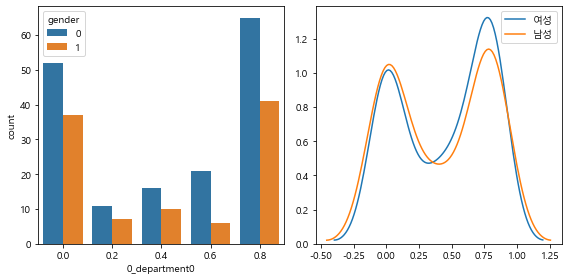

In [66]:
# 고객별 전체방문일수
total_visits = tr.groupby('cust_id')['tran_date'].nunique()
# 고객별 점포별 방문일수
temp_storepivot = pd.pivot_table(tr.query('store_nm in @top12store'), index='cust_id', columns='store_nm', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

# 칼럼명 영문화
engname = temp_storepivot.columns.tolist()
newname = [str(i*10)+'_department' for i in range(len(engname))]
temp_storepivot = temp_storepivot.rename(columns=dict(zip(engname, newname)))

# 고객별 점포별 방문비율
for i in range(len(temp_storepivot.columns)):
    
     temp_storepivot.iloc[:,i] = temp_storepivot.iloc[:,i] / total_visits
    
f = temp_storepivot.reset_index()
f['gender'] = y_train['gender']


bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = [0, 0.2, 0.4, 0.6, 0.8]

for i in range(12):
    
    f[f'{i}_department{i}'] = pd.cut(f[f'{i*10}_department'], bins= bins, labels = labels)
    
    
figure, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.countplot(data=f, x=f['0_department0'], hue='gender', ax=ax[0])

sns.kdeplot(f.query('gender==0')['0_department0'], label='여성', ax=ax[1])
sns.kdeplot(f.query('gender==1')['0_department0'], label='남성', ax=ax[1])
    
plt.tight_layout()
plt.show()    
    
    

<font color = 'blue'> 많이 방문한 지점들 best-12 순위별 구매금액비율

In [67]:
## intersection_store 구매금액비율

for i in trs:
    
    ## nan값 방지
    if len(i) == 232004:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500)})
    else:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500,5982)})
        
    # 고객별 구매금액 총합
    total_amount =  i.groupby('cust_id')['amount'].sum()
    # 고객별 점포별 구매금액
    temp_storepivot = pd.pivot_table(i.query('store_nm in @intersection_store'), index='cust_id', columns='store_nm', values='amount', aggfunc=sum, fill_value=0)

    # 칼럼명 영문화
    engname = temp_storepivot.columns.tolist()
    newname = [str(i*10)+'_amount_ratio' for i in range(len(engname))]
    temp_storepivot = temp_storepivot.rename(columns=dict(zip(engname, newname)))

    # 고객별 점포별 구매금액비율
    for i in range(len(temp_storepivot.columns)):
    
        temp_storepivot.iloc[:,i] = temp_storepivot.iloc[:,i] / total_amount
    
    f = temp_storepivot.reset_index()
    f = pd.merge(merge_tempdf, f, how='outer').fillna(0)
    
    
    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    for i in range(11):
    
        f[f'{i}_amount_ratio{i}'] = pd.cut(f[f'{i*10}_amount_ratio'], bins= bins, labels = labels)
        f = f.drop(f'{i*10}_amount_ratio', axis=1)
    f = f.fillna(0)    
    features.append(f); f

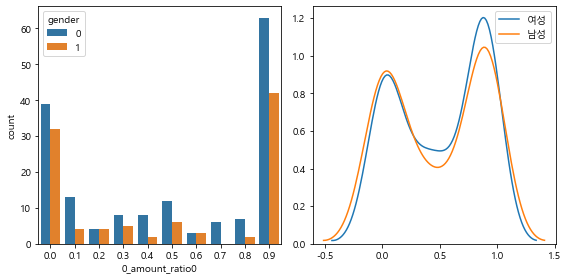

In [68]:
# 고객별 구매금액 총합
total_amount =  tr.groupby('cust_id')['amount'].sum()
# 고객별 점포별 구매금액
temp_storepivot = pd.pivot_table(tr.query('store_nm in @top12store'), index='cust_id', columns='store_nm', values='amount', aggfunc=sum, fill_value=0)

# 칼럼명 영문화
engname = temp_storepivot.columns.tolist()
newname = [str(i*10)+'_amount_ratio' for i in range(len(engname))]
temp_storepivot = temp_storepivot.rename(columns=dict(zip(engname, newname)))

# 고객별 점포별 구매금액비율
for i in range(len(temp_storepivot.columns)):
    
    temp_storepivot.iloc[:,i] = temp_storepivot.iloc[:,i] / total_amount
    
f = temp_storepivot.reset_index()
f['gender'] = y_train['gender']

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in range(12):
    
    f[f'{i}_amount_ratio{i}'] = pd.cut(f[f'{i*10}_amount_ratio'], bins= bins, labels = labels)

figure, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.countplot(data=f, x=f['0_amount_ratio0'], hue='gender', ax=ax[0])

sns.kdeplot(f.query('gender==0')['0_amount_ratio0'], label='여성', ax=ax[1])
sns.kdeplot(f.query('gender==1')['0_amount_ratio0'], label='남성', ax=ax[1])
    
plt.tight_layout()
plt.show()

<font color = 'blue'> 많이 방문한 지점들 best-12 순위별 구매건수
    - 구매건수를 bins1 = [i*5 for i in range(195)]
bins2 = [i*10 for i in range(98)]
labels1 = [i for i in range(194)]
labels2 = [i for i in range(97)]
f[f'0_num_of_pur1'] = pd.cut(f['0_num_of_pur'], bins= bins1, labels = labels1)
f[f'0_num_of_pur2'] = pd.cut(f['0_num_of_pur'], bins= bins2, labels = labels2)5단위, 10단위로 묶어보았을 때 5단위가 좀더 완만하면서 남/녀 그래프 차이가 좀 더 나아서 5단위로 채택하였다

In [69]:
## 고객별 top-12 점포 구매건수

for i in trs:
    
    ## nan값 방지
    if len(i) == 232004:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500)})
    else:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500,5982)})
    
    # 고객별 점포별 구매건수
    temp_storepivot = pd.pivot_table(i.query('store_nm in @intersection_store'), index='cust_id', columns='store_nm', values='amount', aggfunc=np.size, fill_value=0)

    # 칼럼명 영문화
    engname = temp_storepivot.columns.tolist()
    newname = [str(i*10)+'_num_of_pur' for i in range(len(engname))]
    temp_storepivot = temp_storepivot.rename(columns=dict(zip(engname, newname)))

    f = temp_storepivot.reset_index()
    f = pd.merge(merge_tempdf, f, how='outer').fillna(0)
    
    
    for i in range(11):
    
        bins = [i*5 for i in range(round(f[f'{i*10}_num_of_pur'].max()/5) + 2)]
        labels = [i for i in range(len(bins)-1)]
    
        f[f'{i}_num_of_pur{i}'] = pd.cut(f[f'{i*10}_num_of_pur'], bins= bins, labels = labels)
        f = f.drop(f'{i*10}_num_of_pur', axis=1)
    
    f = f.fillna(0)    
    features.append(f); f

In [70]:
f

cust_id 0_num_of_pur0 1_num_of_pur1 2_num_of_pur2 3_num_of_pur3  \
0        3500             0             0             0             0   
1        3501             0             0             0             0   
2        3502             0             0             0           295   
3        3503             0             0             0             0   
4        3504             0             0             0             0   
...       ...           ...           ...           ...           ...   
2477     5977             0             0             0             0   
2478     5978             0             0             0             0   
2479     5979             0             0             0            14   
2480     5980             0             0             0             3   
2481     5981             0             0             0             0   

     4_num_of_pur4 5_num_of_pur5 6_num_of_pur6 7_num_of_pur7 8_num_of_pur8  \
0                3             0             0             0             0   
1                0             0             0             0             0   
2                0             0             0             0             0   
3                1             0             0             0             0   
4                0             0             0             0             0   
...            ...           ...           ...           ...           ...   
2477             1             0             0             0             0   
2478             0             0             0             0             0   
2479             0             0             0             0             0   
2480             0             0             0             0             0   
2481             0             0             0             1             0   

     9_num_of_pur9 10_num_of_pur10  
0                0               0  
1               43               0  
2                0               0  
3                0               0  
4                0               1  
...            ...             ...  
2477             0               0  
2478             0               0  
2479             0               0  
2480             0               0  
2481             0               0  

[2482 rows x 12 columns]

## ────────────────────────────────────────────────────────

### 4.  제품적 관점

   - 구매추세 패턴1
        - 주구매 상품1: goods_id
        - 주구매 상품2: gds_grp_nm
        - 주구매 상품3: gds_grp_mclas_nm
   - 구매추세 패턴2
        - 상반기, 하반기 총 구매금액 비교해서 상승세, 하락세 나누기
   - 상품별 구매순서 -> 가장 먼저 방문하는 상품대분류명군
   - 구매상품종류1(goods_id), 구매상품종류2(gds_grp_nm), 구매상품종류3(gds_grp_mclas_nm)
   - Top-10 베스트 셀러(gds_grp_mclas_nm)에 대한 구매 금액/건수/여부
   - 많이 구매한 상품소분류별 best-x 구매금액비율, 구매건수비율(3471 중 x)
   - 많이 구매한 상품중분류별 best-y 구매금액비율, 구매건수비율(324 중 y)
   - 많이 구매한 상품대분류별 best-z 구매금액비율, 구매건수비율(49 중 z)

 <font color = 'blue'> 주구매상품1

->  주구매 상품: 가장 많이 구매한 상품(goods_id)
     - 총 3471개 물품 중 3500명이 가장 많이 사는 물품들은 850개정도로 겹치는 물품들이 있다

In [71]:
## goods_id 구매한 물품 중 가장 많이 구매한 물품

for i in trs:
    
    f = i.groupby('cust_id')['goods_id'].agg([
        ('main_product_goods', lambda x: x.value_counts().index[0])
    ]).reset_index()
    features.append(f); f

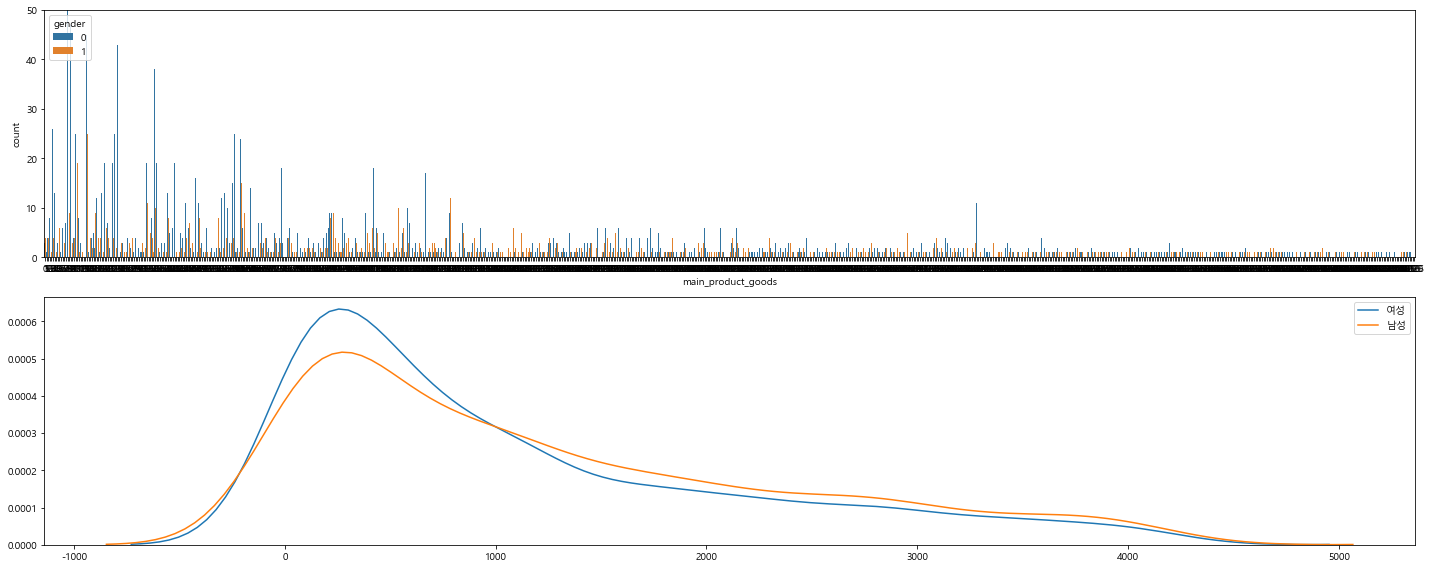

In [72]:
f = tr.groupby('cust_id')['goods_id'].agg([
    ('main_product_goods', lambda x: x.value_counts().index[0])
]).reset_index()

str_name = f.main_product_goods.unique().tolist()
num_name = [i*5 for i in range(len(str_name))]
f.main_product_goods = f.main_product_goods.map(dict(zip(str_name, num_name)))

f['gender'] = y_train['gender']

figure, ax = plt.subplots(2, 1, figsize=(20, 8))

sns.countplot(data=f, x='main_product_goods', hue='gender', ax=ax[0])
ax[0].set_ylim(0,50)
sns.kdeplot(f.query('gender==0').main_product_goods, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').main_product_goods, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 주구매상품2
    - 총 324개 중 203개로 겹치는 gds_grp_nm이 존재한다
    - 겹치면서 많이 구매한 물품들에 있어서 남/녀를 구분할 수 있는 제품들이 있기 때문에 피쳐로 채택

In [73]:
for i in trs:
    
    f = i.groupby('cust_id')['gds_grp_nm'].agg([
        ('main_product_nm', lambda x: x.value_counts().index[0])
    ]).reset_index()
    
    # 주구매상품중분류 문자를 숫자로 바꿔주기
    str_name = f.main_product_nm.unique().tolist()
    num_name = [i for i in range(len(str_name))]
    f.main_product_nm = f.main_product_nm.map(dict(zip(str_name, num_name)))
    
    features.append(f); f

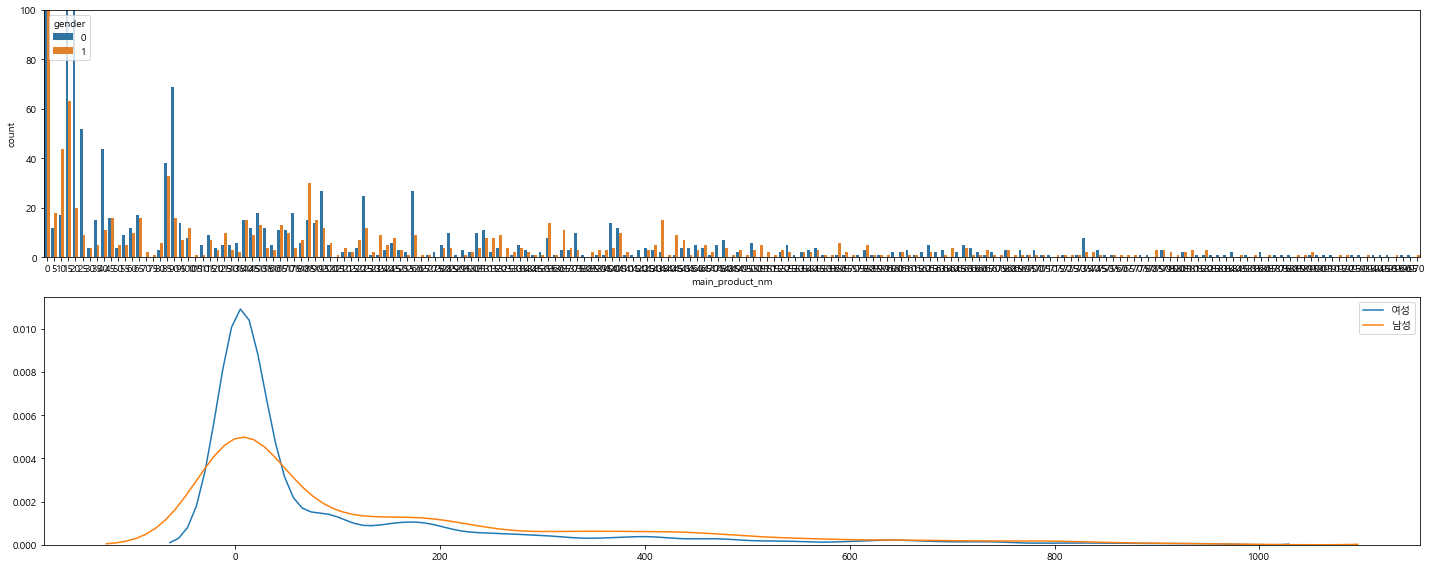

In [74]:
f = tr.groupby('cust_id')['gds_grp_nm'].agg([('main_product_nm', lambda x: x.value_counts().index[0])]).reset_index()

str_name = f.main_product_nm.unique().tolist()
num_name = [i*5 for i in range(len(str_name))]
f.main_product_nm = f.main_product_nm.map(dict(zip(str_name, num_name)))

f['gender'] = y_train['gender']

figure, ax = plt.subplots(2, 1, figsize=(20, 8))

sns.countplot(data=f, x='main_product_nm', hue='gender', ax=ax[0])
ax[0].set_ylim(0,100)
sns.kdeplot(f.query('gender==0').main_product_nm, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').main_product_nm, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 주구매상품3
    - 총 49개 중 42개로 겹치는 gds_grp_mclas_nm이 존재한다
    - 겹치면서 많이 구매한 물품들에 있어서 남/녀를 구분할 수 있는 제품들이 있기 때문에 피쳐로 채택

가장 많이 구매한 상품(gds_grp_mclas_nm)


In [75]:
for i in trs:

    f = i.groupby('cust_id')['gds_grp_mclas_nm'].agg([
        ('main_product_mclas', lambda x: x.value_counts().index[0])
    ]).reset_index()
    
    # 주구매상품대분류 문자를 숫자로 바꿔주기
    str_name = f.main_product_mclas.unique().tolist()
    num_name = [i for i in range(len(str_name))]
    f.main_product_mclas = f.main_product_mclas.map(dict(zip(str_name, num_name)))

    features.append(f); f

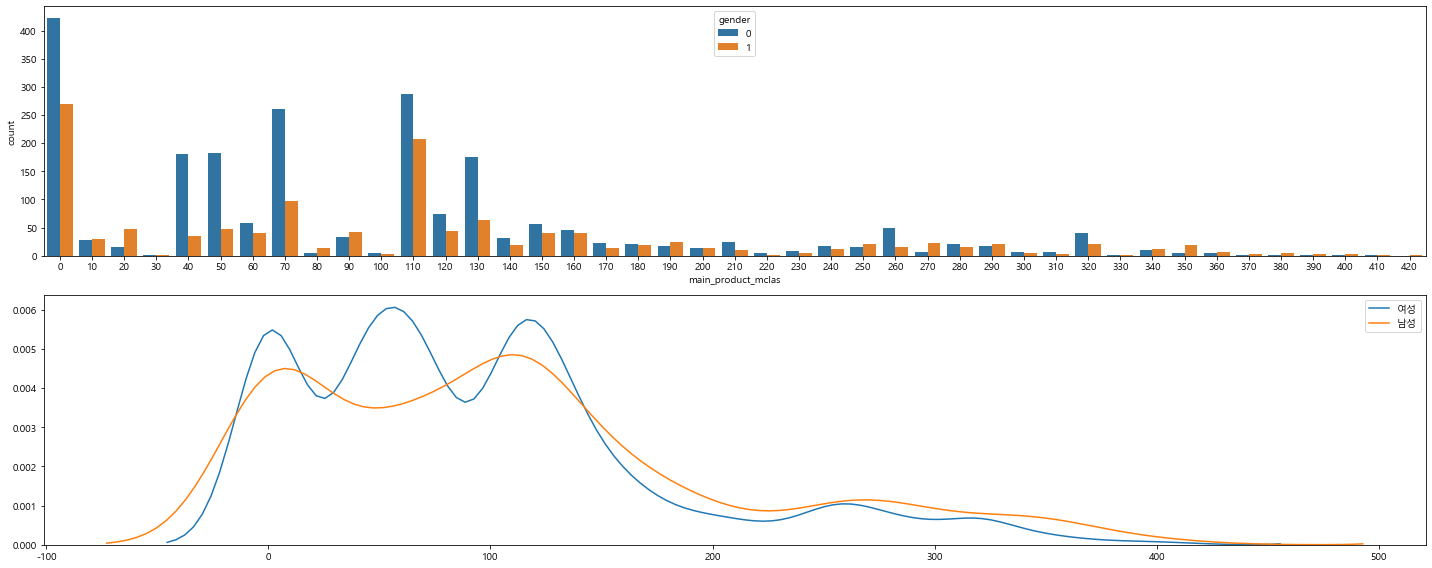

In [76]:
f = tr.groupby('cust_id')['gds_grp_mclas_nm'].agg([('main_product_mclas', lambda x: x.value_counts().index[0])]).reset_index()

# 상품대분류명군 문자를 숫자로 바꿔주기
str_name = f.main_product_mclas.unique().tolist()
num_name = [i*10 for i in range(len(str_name))]
f.main_product_mclas = f.main_product_mclas.map(dict(zip(str_name, num_name)))

f['gender'] = y_train['gender']

figure, ax = plt.subplots(2, 1, figsize=(20, 8))

sns.countplot(data=f, x='main_product_mclas', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').main_product_mclas, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').main_product_mclas, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()


<font color = 'blue'> 상품별 구매순서

In [77]:
# 가장 먼저 방문하는 상품대분류명군

temp_lst = []
for i in range(3500):
    temp_lst.append(tr.query(f'cust_id == {i}').drop_duplicates('tran_date')['gds_grp_mclas_nm'].value_counts().index[0])

f = pd.DataFrame({'cust_id': np.arange(3500)})
f['first_visit_place'] = temp_lst

# 상품대분류명군 문자를 숫자로 바꿔주기
str_name = f.first_visit_place.unique().tolist()
num_name = [i*5 for i in range(len(str_name))]
f.first_visit_place = f.first_visit_place.map(dict(zip(str_name, num_name)))

features.append(f); f

cust_id  first_visit_place
0           0                  0
1           1                  5
2           2                 10
3           3                 15
4           4                 20
...       ...                ...
3495     3495                120
3496     3496                 25
3497     3497                100
3498     3498                  0
3499     3499                  0

[3500 rows x 2 columns]

In [78]:
# 가장 먼저 방문하는 상품대분류명군

temp_lst = []
for i in range(3500,5982):
    temp_lst.append(tr2.query(f'cust_id == {i}').drop_duplicates('tran_date')['gds_grp_mclas_nm'].value_counts().index[0])

f = pd.DataFrame({'cust_id': np.arange(3500,5982)})
f['first_visit_place'] = temp_lst

  # 상품대분류명군 문자를 숫자로 바꿔주기
str_name = f.first_visit_place.unique().tolist()
num_name = [i*5 for i in range(len(str_name))]
f.first_visit_place = f.first_visit_place.map(dict(zip(str_name, num_name)))

features.append(f); f

cust_id  first_visit_place
0        3500                  0
1        3501                  5
2        3502                 10
3        3503                 15
4        3504                 20
...       ...                ...
2477     5977                  0
2478     5978                 40
2479     5979                195
2480     5980                120
2481     5981                105

[2482 rows x 2 columns]

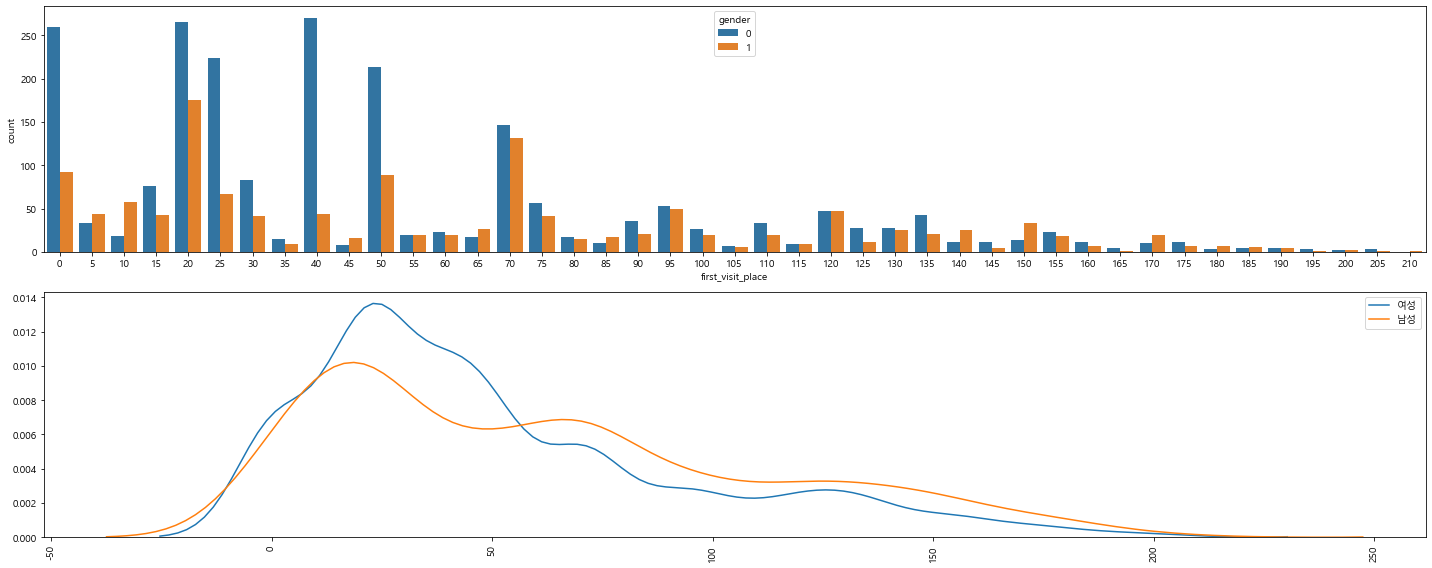

In [79]:
temp_lst = []
for i in range(3500):
    temp_lst.append(tr.query(f'cust_id == {i}').drop_duplicates('tran_date')['gds_grp_mclas_nm'].value_counts().index[0])

f = pd.DataFrame({'cust_id': np.arange(3500)})
f['first_visit_place'] = temp_lst

# 상품대분류명군 문자를 숫자로 바꿔주기
str_name = f.first_visit_place.unique().tolist()
num_name = [i*5 for i in range(len(str_name))]
f.first_visit_place = f.first_visit_place.map(dict(zip(str_name, num_name)))

f['gender'] = y_train['gender']

figure, ax = plt.subplots(2, 1, figsize=(20, 8))

sns.countplot(data=f, x='first_visit_place', hue='gender', ax=ax[0])
plt.xticks(rotation=90)
sns.kdeplot(f.query('gender==0').first_visit_place, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').first_visit_place, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 구매상품종류1(goods_id), 구매상품종류2(gds_grp_nm), 구매상품종류3(gds_grp_mclas_nm)

In [80]:
for i in trs:
    
    f = i.groupby('cust_id').agg({
        'goods_id': [('num_pur_type1', lambda x: x.nunique())],
        'gds_grp_nm': [('num_pur_type2', lambda x: x.nunique())],
        'gds_grp_mclas_nm': [('num_pur_type3', lambda x: x.nunique())]
    })

    f.columns = f.columns.droplevel()  # 동일한 코드: f.columns = [j for _, j in f.columns]
    f=f.reset_index()
    features.append(f); f

In [81]:
f = tr.groupby('cust_id').agg({
    'goods_id': [('num_pur_type1', lambda x: x.nunique())],
    'gds_grp_nm': [('num_pur_type2', lambda x: x.nunique())],
    'gds_grp_mclas_nm': [('num_pur_type3', lambda x: x.nunique())]
})

f.columns = f.columns.droplevel()  # 동일한 코드: f.columns = [j for _, j in f.columns]
f=f.reset_index()

f['gender'] = y_train['gender']

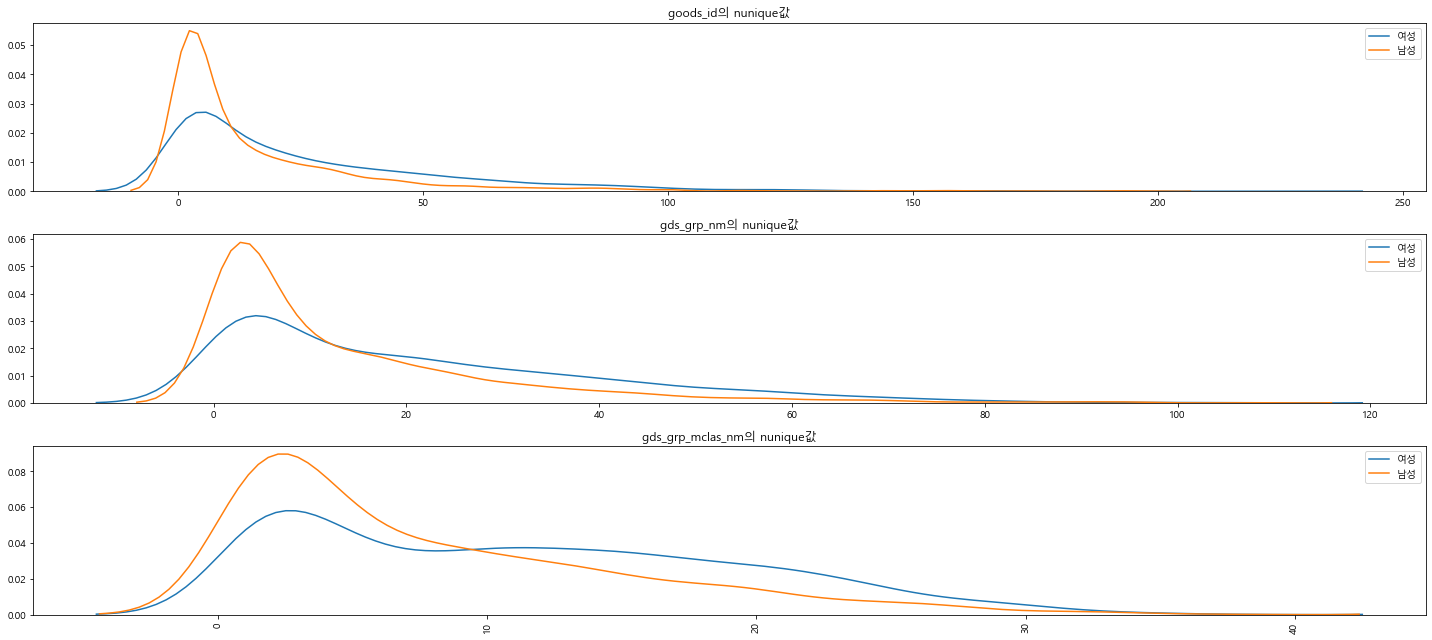

In [82]:
figure , ax = plt.subplots(3, 1, figsize=(20,9))

for i in range(3):
    sns.kdeplot(f.query('gender==0')[f'num_pur_type{i+1}'], label='여성', ax=ax[i])
    sns.kdeplot(f.query('gender==1')[f'num_pur_type{i+1}'], label='남성', ax=ax[i])
ax[0].set_title('goods_id의 nunique값')
ax[1].set_title('gds_grp_nm의 nunique값')
ax[2].set_title('gds_grp_mclas_nm의 nunique값')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 상품 분류별  top-x 구매금액비율 , 구매건수
 - 상품분류별 중 90퍼센트 이상을 차지하는 상품들의 구매금액비율과 구매건수를 구한다
 - train과 test에서 겹치는 부분을 뽑아내기 때문에 칼럼 수가 줄어든다.
        - goods_id(상품소분류별) top550 구매금액비율, 구매건수
        - gds_grp_nm(상품중분류별) top75 구매금액비율, 구매건수
        - gds_grp_mclas_nm(상품대분류별) top25 구매금액비율, 구매건수

<font color = 'blue'> 많이 구매한 상품소분류별 best-x 구매금액비율, 구매건수(3471 중 x)

In [83]:
top550goods_all = []

for i in trs:

    ## 전체 구매금액
    total = i.amount.sum()

    ## 전체 구매금액 중 goods_id top550이 전체의 90퍼센트 정도를 차지한다.

    top550 = i.groupby('goods_id')['amount'].sum().reset_index().sort_values('amount', ascending=False)[:550]

    top550sum = top550['amount'].sum()

    top550goods = top550['goods_id'].tolist()

    top550goods_all.append(top550goods)

    print(top550sum / total)

0.9034186144204891
0.910431874144973


In [84]:
## 교차항목 뽑아내기

train_top550 = top550goods_all[0]; print(len(train_top550))
test_top550 = top550goods_all[1]; print(len(test_top550))
print()
intersection550 = list(set(train_top550).intersection(test_top550)); print('겹치는 항목:',len(intersection550))

550
550

겹치는 항목: 483


In [85]:
for i in trs:
    ## nan값 방지
    if len(i) == 232004:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500)})
    else:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500,5982)})
    
    # 고객별 전체 구매금액
    totalsum = i.groupby('cust_id')['amount'].sum()

    temp_goodsdf = i.query('goods_id in @intersection550')
    
## intersection550 구매금액비율    
    temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='goods_id', values='amount', aggfunc=sum, fill_value=0)
    
    for i in range(len(temp_goodspivot.columns)):
        temp_goodspivot.iloc[:,i] = temp_goodspivot.iloc[:,i] / totalsum

    f = temp_goodspivot.reset_index()
    f = pd.merge(merge_tempdf, f, how='outer').fillna(0)

## intersection550 구매금액건수

    temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='goods_id', values='amount', aggfunc=np.size, fill_value=0)

    # 변수명이 겹치는 것을 막기 위해서 변수명을 다르게 바꿔주는 과정
    oldname = temp_goodspivot.columns.tolist()
    newname = [(str(i)+'_buy') for i in oldname]
    temp_goodspivot = temp_goodspivot.rename(columns = dict(zip(oldname, newname)))

    f2 = temp_goodspivot.reset_index() # 3258행
    f = pd.merge(f, f2, how='outer').fillna(0)

    features.append(f); f

<font color = 'blue'> 많이 구매한 상품중분류별 best-y 구매금액비율, 구매건수비율(324 중 y)

In [86]:
top75goods_all = []

for i in trs:
    
    ## 전체 구매금액
    total = i.amount.sum()

    ## 전체 구매금액 중 gds_grp_nm top75이 전체의 90퍼센트 정도를 차지한다.

    top75 = i.groupby('gds_grp_nm')['amount'].sum().reset_index().sort_values('amount', ascending=False)[:75]

    top75sum = top75['amount'].sum()

    top75goods = top75['gds_grp_nm'].tolist()
    
    top75goods_all.append(top75goods)

    print(top75sum / total)

0.9099637919037719
0.9127326259610689


In [87]:
## 교차항목 뽑아내기

train_top75 = top75goods_all[0]; print(len(train_top75))
test_top75 = top75goods_all[1]; print(len(test_top75))
print()
intersection75 = list(set(train_top75).intersection(test_top75)); print('겹치는 항목:',len(intersection75))

75
75

겹치는 항목: 72


In [88]:
for i in trs:
    ## nan값 방지
    if len(i) == 232004:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500)})
    else:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500,5982)})
        
    # 고객별 전체 구매금액
    totalsum = i.groupby('cust_id')['amount'].sum()

## intersection75 구매금액비율
    temp_goodsdf = i.query('gds_grp_nm in @intersection75')

    temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='gds_grp_nm', values='amount', aggfunc=sum, fill_value=0)

    # 변수명 영문화
    kor_name = temp_goodspivot.columns.tolist()
    newname = [str(i*3)+'grp_nm' for i in range(len(kor_name))]
    temp_goodspivot = temp_goodspivot.rename(columns=dict(zip(kor_name, newname)))    
    
    for i in range(len(temp_goodspivot.columns)):
        temp_goodspivot.iloc[:,i] = temp_goodspivot.iloc[:,i] / totalsum

    f = temp_goodspivot.reset_index()
    f = pd.merge(merge_tempdf, f, how='outer').fillna(0)


## intersection75 구매금액건수

    temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='gds_grp_nm', values='amount', aggfunc=np.size, fill_value=0)

    # 변수명 영문화
    kor_name = temp_goodspivot.columns.tolist()
    newname = [str(i*3)+'grp_nm_buy' for i in range(len(kor_name))]
    temp_goodspivot = temp_goodspivot.rename(columns=dict(zip(kor_name, newname)))  

    f2 = temp_goodspivot.reset_index()
    f = pd.merge(f, f2, how='outer').fillna(0)

    features.append(f); f


<font color = 'blue'> 많이 구매한 상품대분류별 best-z 구매금액비율, 구매건수비율(49 중 z)

In [89]:
top25goods_all = []

for i in trs:
    
    ## 전체 구매금액
    total = i.amount.sum()

    ## 전체 구매금액 중 gds_grp_mclas_nm top25이 전체의 90퍼센트 정도를 차지한다.
    top25 = i.groupby('gds_grp_mclas_nm')['amount'].sum().reset_index().sort_values('amount', ascending=False)[:25]
    
    top25sum = top25['amount'].sum()
    
    top25goods = top25['gds_grp_mclas_nm'].tolist()
    
    top25goods_all.append(top25goods)

    print(top25sum / total)

0.9232754143371885
0.9259379619745215


In [90]:
## 교차항목 뽑아내기

train_top25 = top25goods_all[0]; print(len(train_top25))
test_top25 = top25goods_all[1]; print(len(test_top25))
print()
intersection25 = list(set(train_top25).intersection(test_top25)); print('겹치는 항목:',len(intersection25))

25
25

겹치는 항목: 24


In [91]:
for i in trs:
    ## nan값 방지
    if len(i) == 232004:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500)})
    else:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500,5982)})

    # 고객별 전체 구매금액
    totalsum = i.groupby('cust_id')['amount'].sum()
    
## intersection25 구매금액비율
    temp_goodsdf = i.query('gds_grp_mclas_nm in @intersection25')

    temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='gds_grp_mclas_nm', values='amount', aggfunc=sum, fill_value=0)

    # 변수명 영문화
    kor_name = temp_goodspivot.columns.tolist()
    newname = [str(i*3)+'mclas_nm' for i in range(len(kor_name))]
    temp_goodspivot = temp_goodspivot.rename(columns=dict(zip(kor_name, newname)))   
    
    for i in range(len(temp_goodspivot.columns)):
        temp_goodspivot.iloc[:,i] = temp_goodspivot.iloc[:,i] / totalsum

    f = temp_goodspivot.reset_index()
    f = pd.merge(merge_tempdf, f, how='outer').fillna(0)

## intersection25 구매건수

    temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='gds_grp_mclas_nm', values='amount', aggfunc=np.size, fill_value=0)

    # 변수명 영문화
    kor_name = temp_goodspivot.columns.tolist()
    newname = [str(i*3)+'mclas_nm_buy' for i in range(len(kor_name))]
    temp_goodspivot = temp_goodspivot.rename(columns=dict(zip(kor_name, newname))) 

    f2 = temp_goodspivot.reset_index()
    f = pd.merge(f, f2, how='outer').fillna(0)

    features.append(f); f

## ────────────────────────────────────────────────────────

### 5.  기타적 관점

none

## 남녀가 어떤 상품들을 구매하는지, 상품으로써 남녀를 구분하는 피쳐를 생성하고자 한다

 ### process
  #### ch.1 -> 남성경향제품 구매여부(조건: 남성이 여성보다 구매수가 많으면서 남성이 적어도 3번이상 구매한 제품)
    
    - 1. 상품대분류명 살펴보기(gds_grp_mclas_nm)
    - 2. 상품중분류명 살펴보기(gds_grp_nm)
    - 3. 상품소분류명 살펴보기(goods_id)
    - 4. goods_id에서 남성이 여성보다 더 많이 구매한 물품목록 뽑아내기
    - 5. 뽑아낸 물품목록으로 피쳐 생성하기
    
 ***
  #### ch.2 -> 여성경향제품 구매여부(조건: 여성만 구매 & 여성이 최소 해당 물품 3회이상 구매 & 여성 최소 3명이 해당 물품구매)
              -> (or 이 아니라 and로 모두 해당 조건을 모두 만족하는 물품만 뽑았다)
    - 1. 남성만 혹은 여성만 구매하는 제품을 조사
    - 2. 여성만 구매한 제품목록 뽑아내기
    - 3. 뽑아낸 물품목록으로 피쳐 생성하기
 ***
    -> 뽑아낸 피쳐 저장: train_eda_gender_tendency, test_eda_gender_tendency

## ch.1
### 1. countplot으로 상품대분류명 grp_mclas_nm 살펴보기

상품대분류명들을 다시 한번 관련있는 상품들끼리 묶어서 all_mclas에 넣었다   
그리고 다음과 같이 모든 상품대분류명을 시각화하여 보았더니 모든 대분류명 상품군에 있어서 여성의 구매수가 더 많았다

 - 이는 데이터의 불균형때문에 일어난 것으로 보이며
 - 대분류명에서는 남성이 더 많이 구매한 물품을 찾아볼 수 없었으므로 더 구체적으로 상품중중분류명(gds_grp_nm)을 살펴보기로 하였다
 
     -> 데이터 내에서 남성을 구분할 수 있는 상품군을 찾아내야 할 것 같다

In [92]:
clothes =['시티웨어', '디자이너', '셔츠', '란제리/내의', '섬유잡화', '캐주얼', '구두', '피혁잡화', '모피/피혁']

clothes2 = ['남성정장', '남성 캐주얼', '남성 트랜디', '커리어', '기타의류']

cosmos = ['화장품', '액세서리']

luxury = ['명품', '준보석/시계', '보석']

sports = ['스포츠','골프', '트래디셔널']

foods = ['축산가공', '건강식품','육류', '수산품', '젓갈/반찬', '가공식품', '농산물', '차/커피' ]

furniture = ['가구', '악기']

etc = ['기타', '침구/수예', '일용잡화', '주방용품', '식기', '주류', '생활잡화']

electronics = ['주방가전', '소형가전', '대형가전', '통신/컴퓨터', '전자/전기']

kids = ['아동', '교복', '문구/팬시']

ambiguous = ['웨딩', '멀티(아울렛)']

all_mclas = [clothes, clothes2, cosmos, luxury, sports, foods, furniture, etc, electronics, kids, ambiguous]

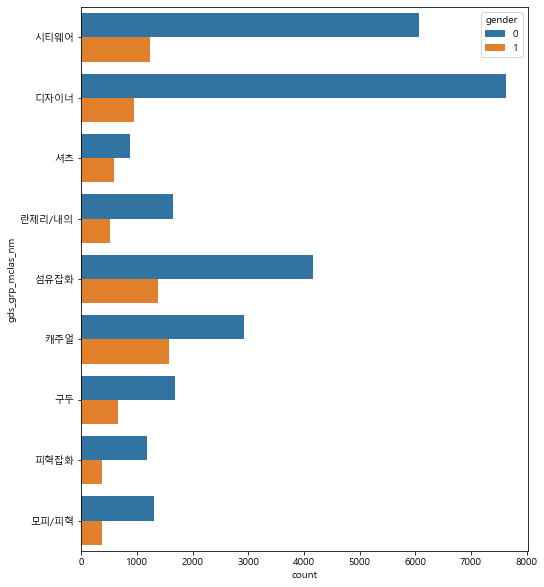

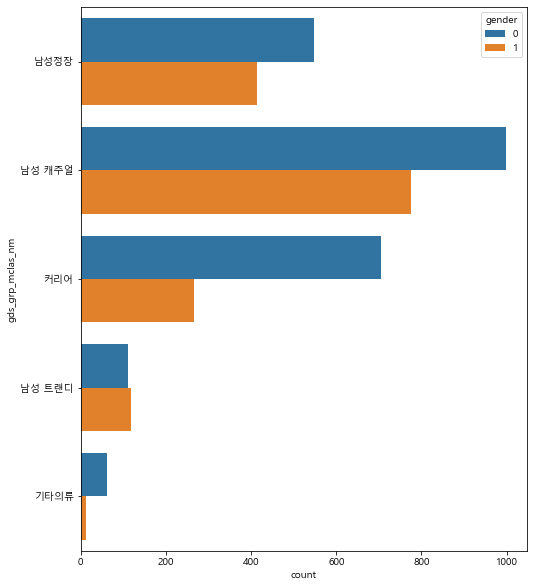

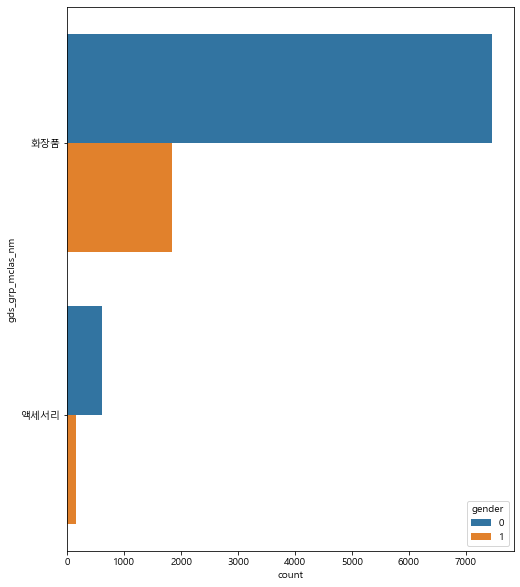

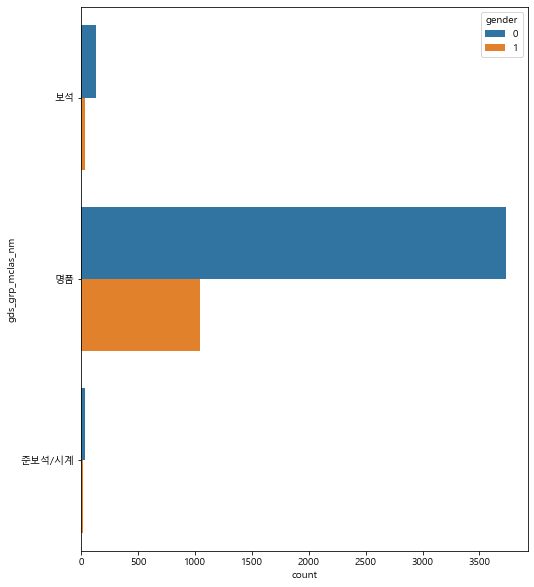

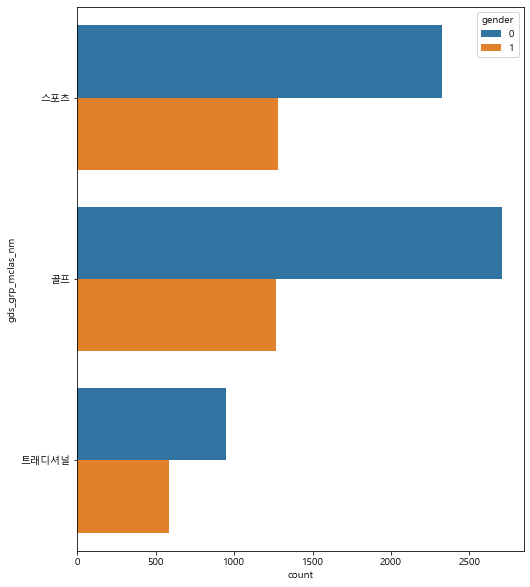

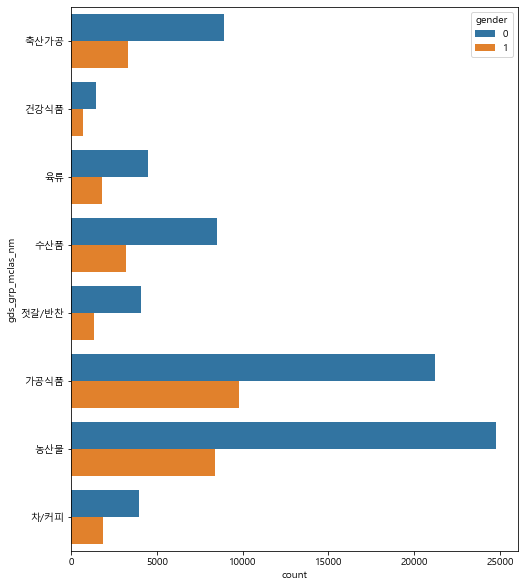

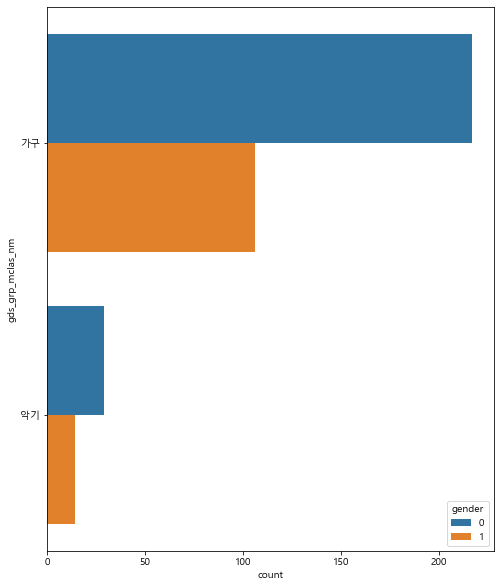

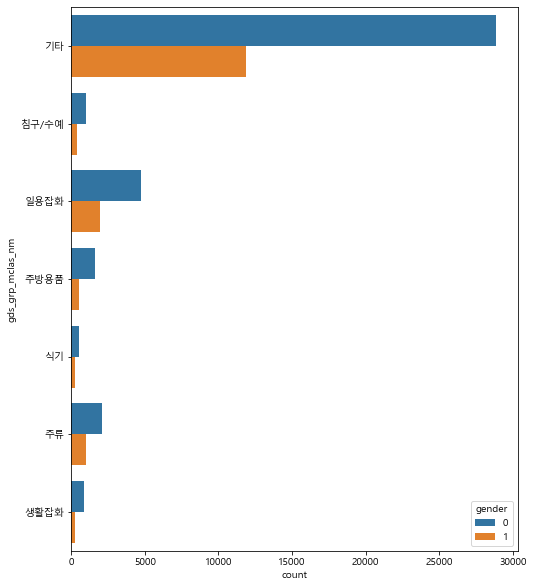

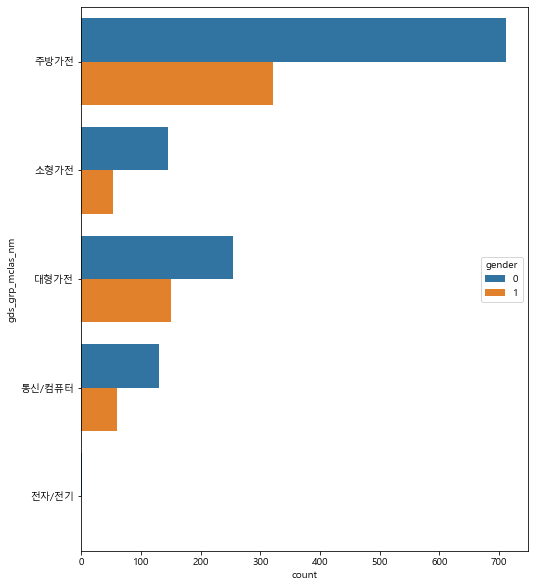

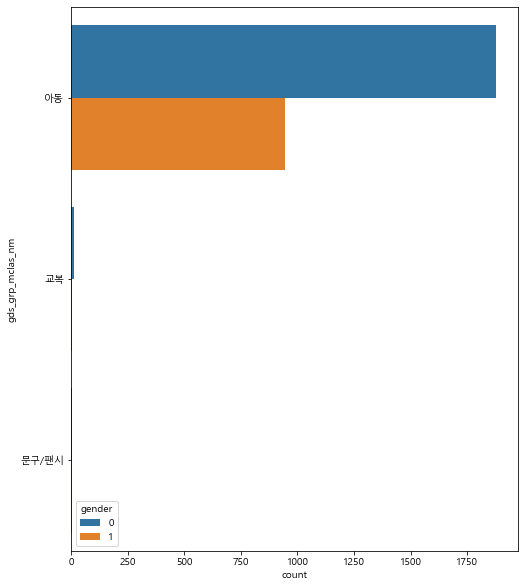

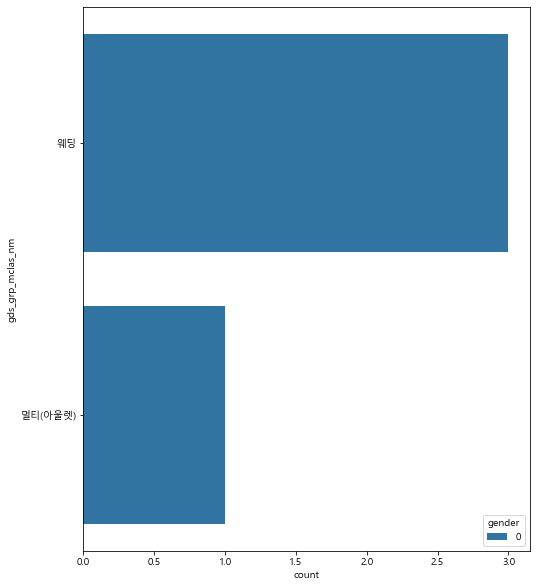

In [93]:
plt.rcParams['figure.figsize'] = [8, 10] # [width, height] (inches)
for mclas in all_mclas:
    
    display(sns.countplot(data=tr.query(f'gds_grp_mclas_nm in {mclas}'), y='gds_grp_mclas_nm', hue='gender'))
    plt.show()

### 2. countplot 으로 상품중분류명 grp_nm 살펴보기

 - 상품중분류명을 countplot으로 살펴본 결과 여성보다 남성이 구매수가 더 많은 상품들이 있다
     - 트랜디, 명품남성, 유아용품 이 이에 해당한다
 - 명품남성 같은 경우에는 남여 예측에 좋은 구분이 되겠지만, 다른 남성코너에서는 실제로 여성의 구매가 더 많았으므로 이는 남녀를 구분하기에 아직 정보가 부족하다고 생각되어서 상품소분류명까지 보기로 하였다

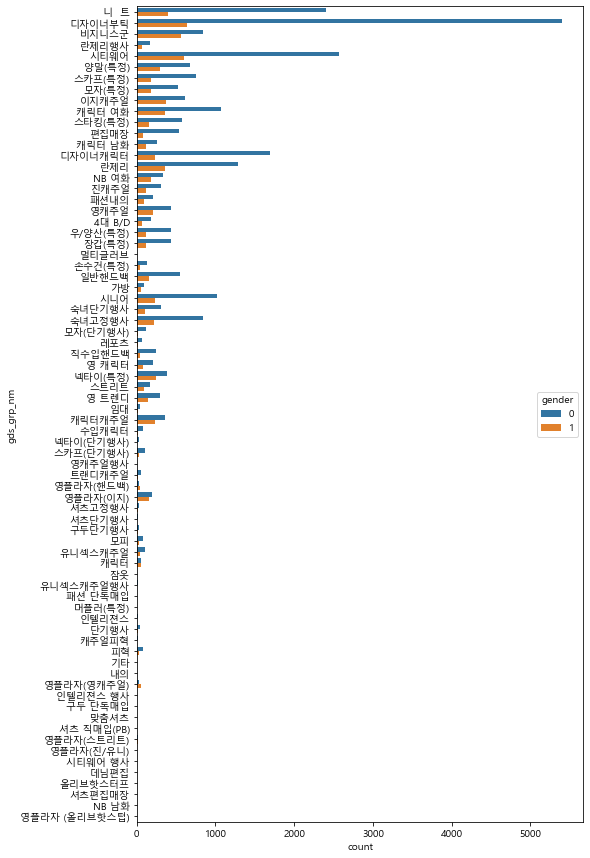

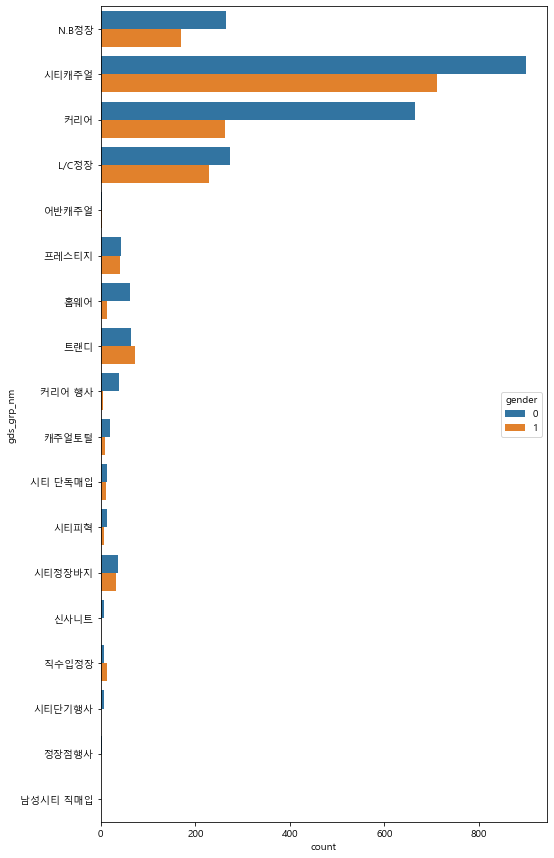

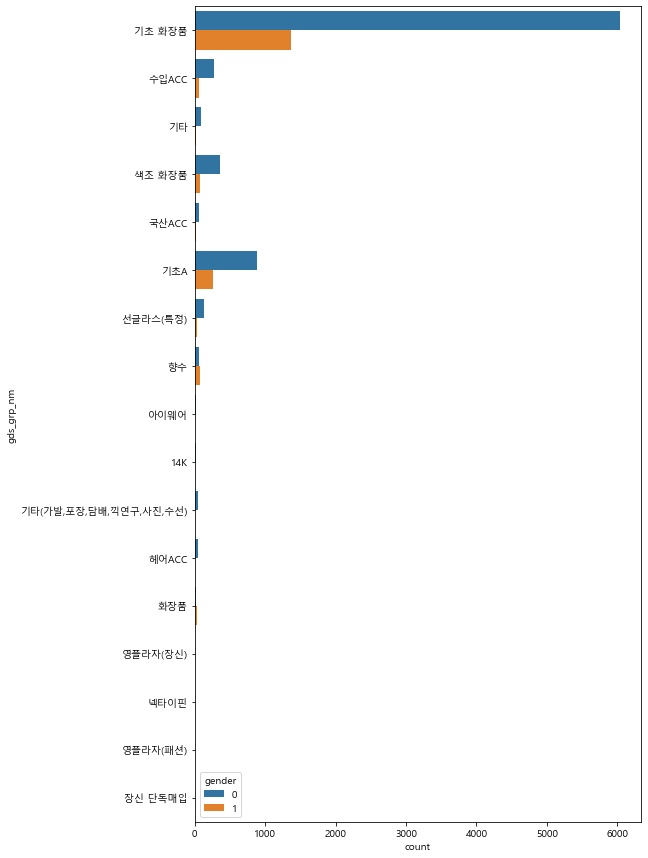

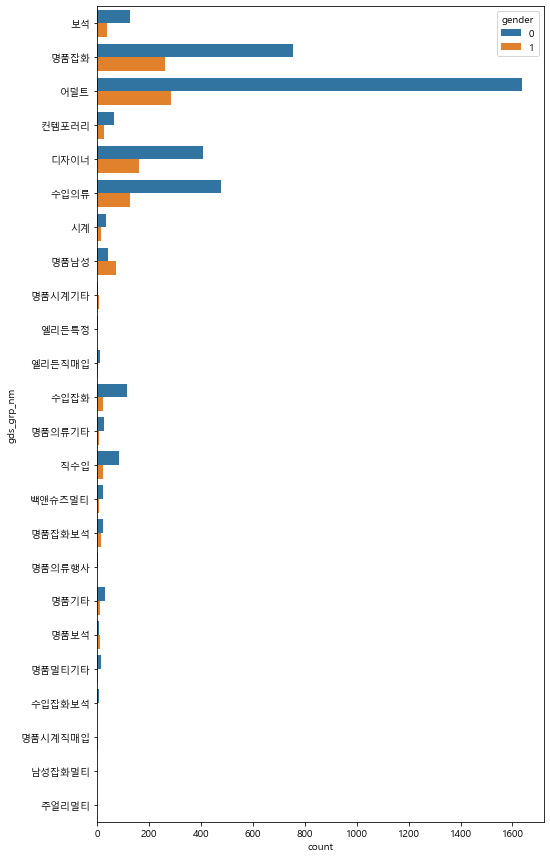

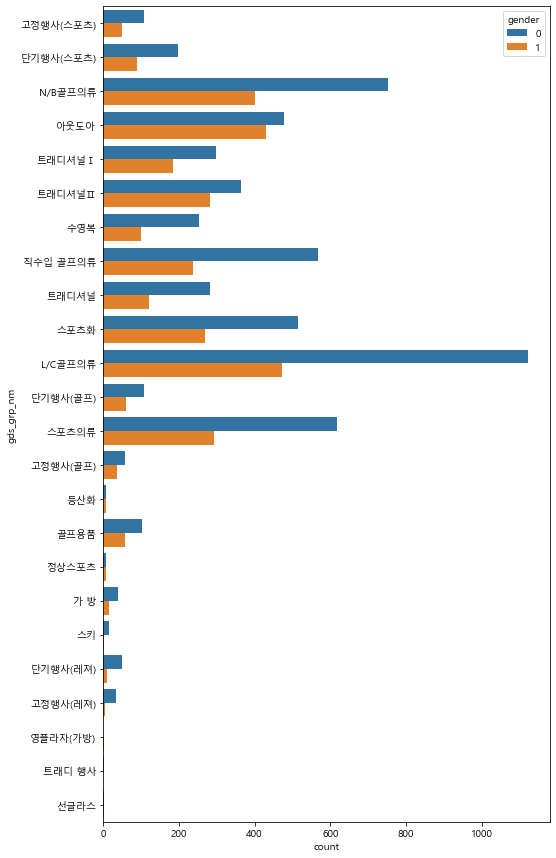

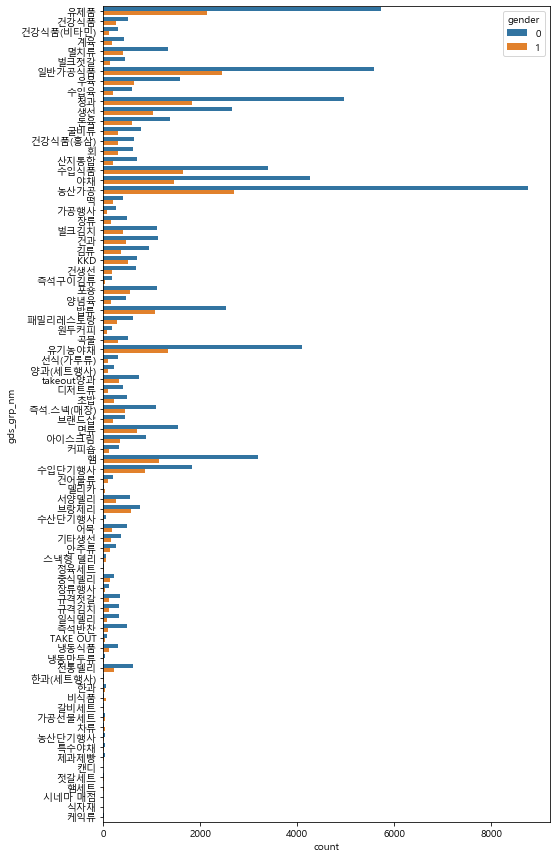

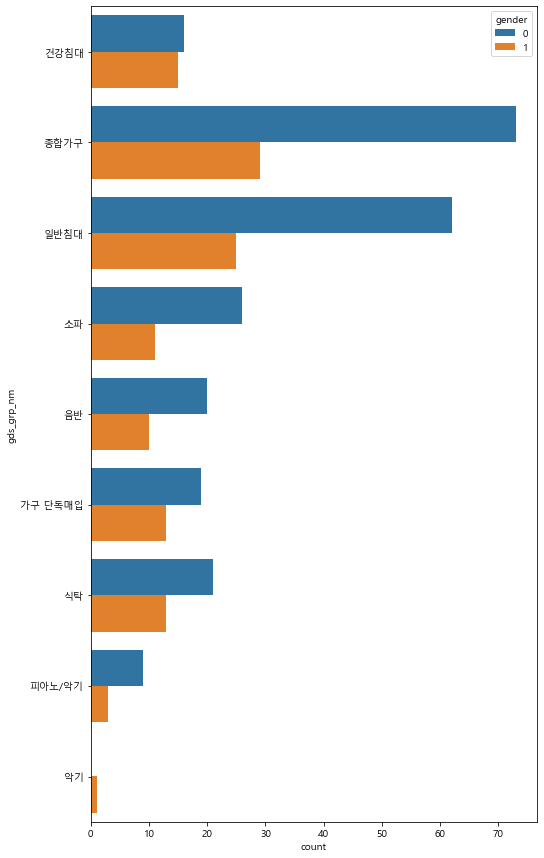

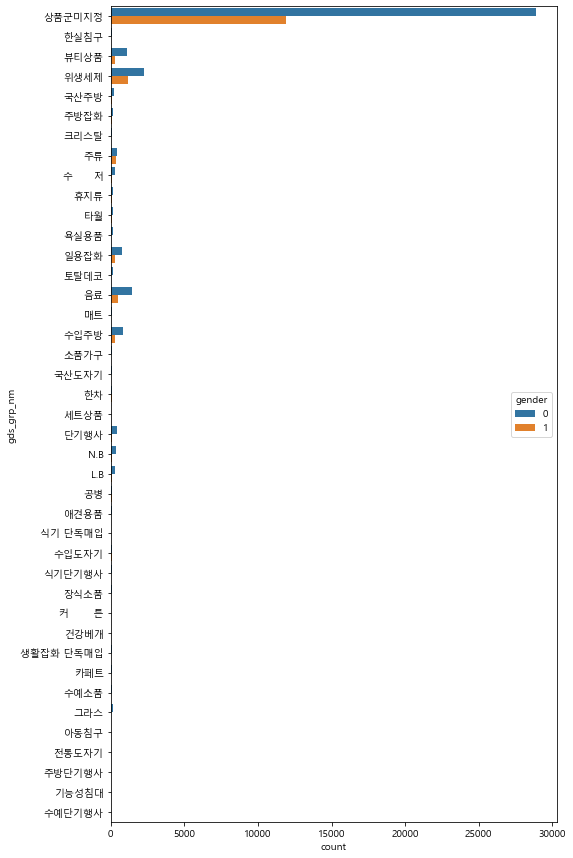

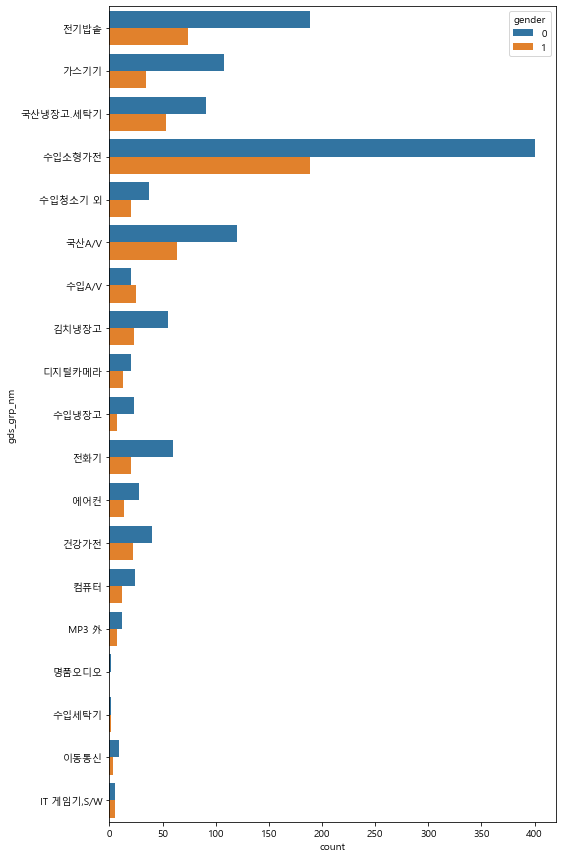

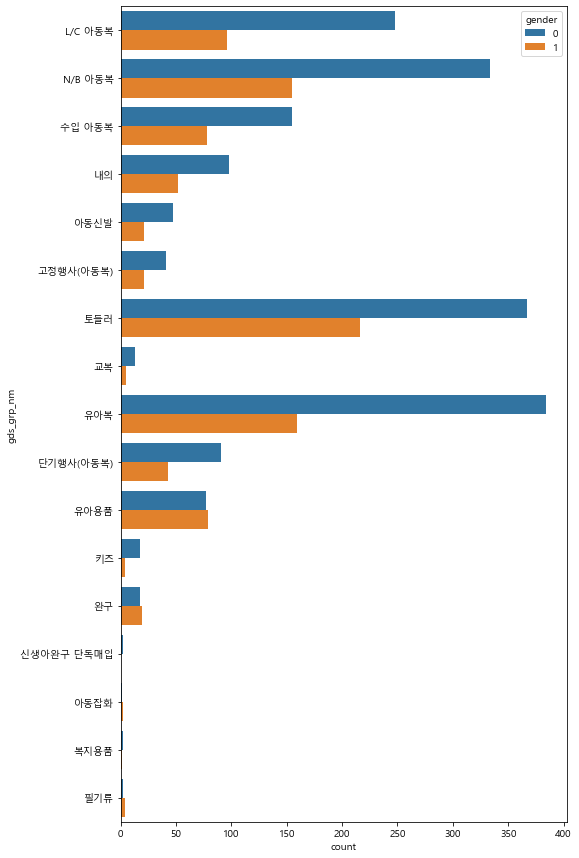

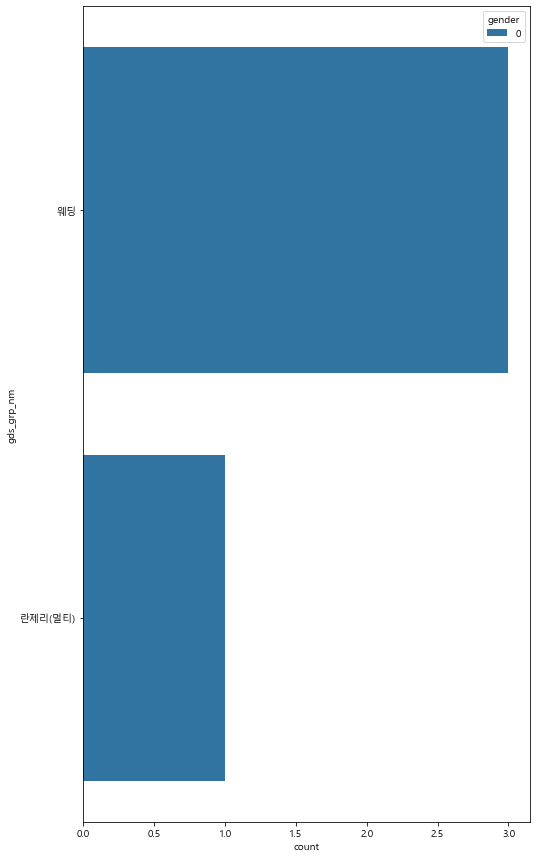

In [94]:
plt.rcParams['figure.figsize'] = [8, 15] # [width, height] (inches)
for mclas in all_mclas:
    
    display(sns.countplot(data=tr.query(f'gds_grp_mclas_nm in {mclas}'), y='gds_grp_nm', hue='gender'))
    plt.show()

### 3. countplot 으로 상품소분류명 살펴보기

 - 물품이 너무 많아 잘 보이지는 않지만 남성 전용의 물품인지 남성경향의 물품인지 확실히 남성들이 더 많이 구매하는 물품들이 보인다
 - 이에 그러한 goods_id 물품들을 모두 뽑아내기로 하였다

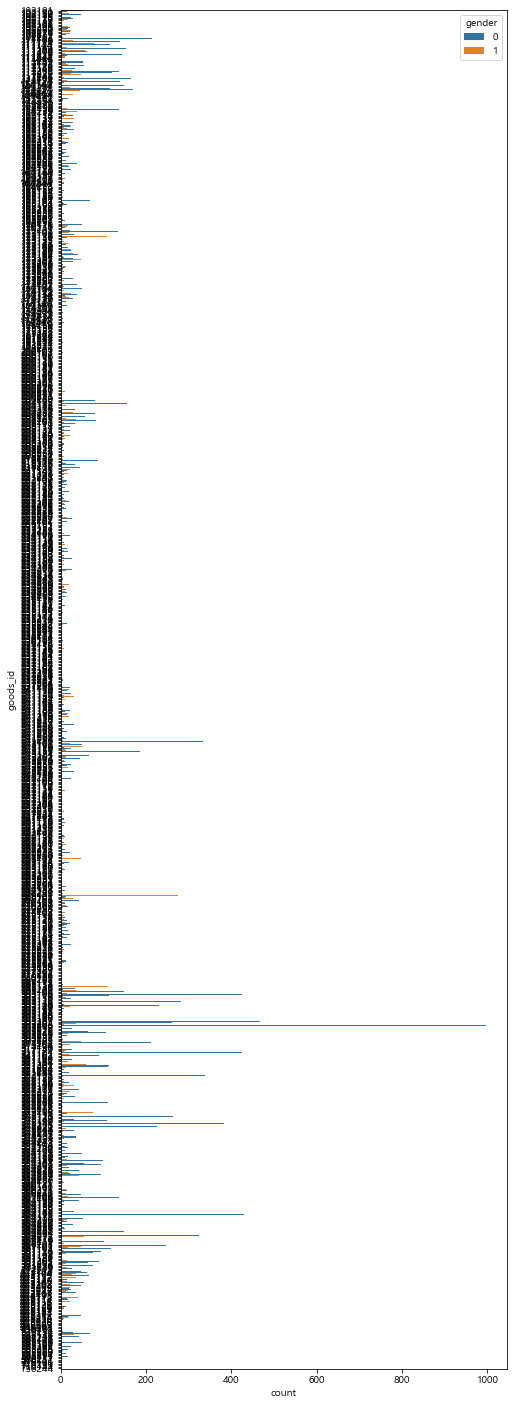

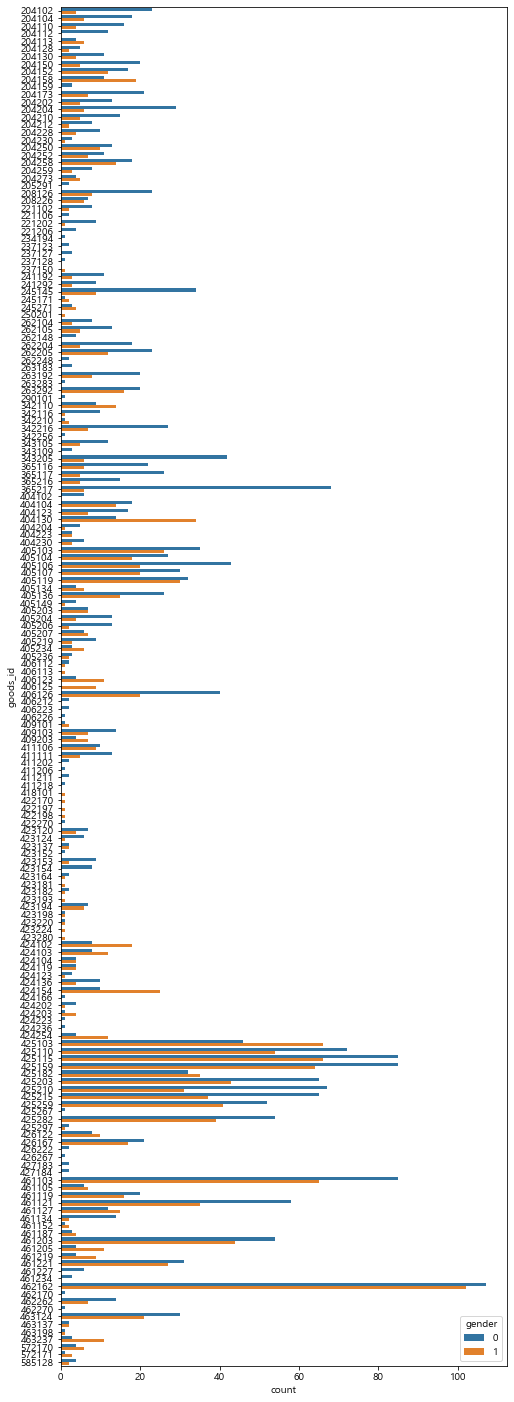

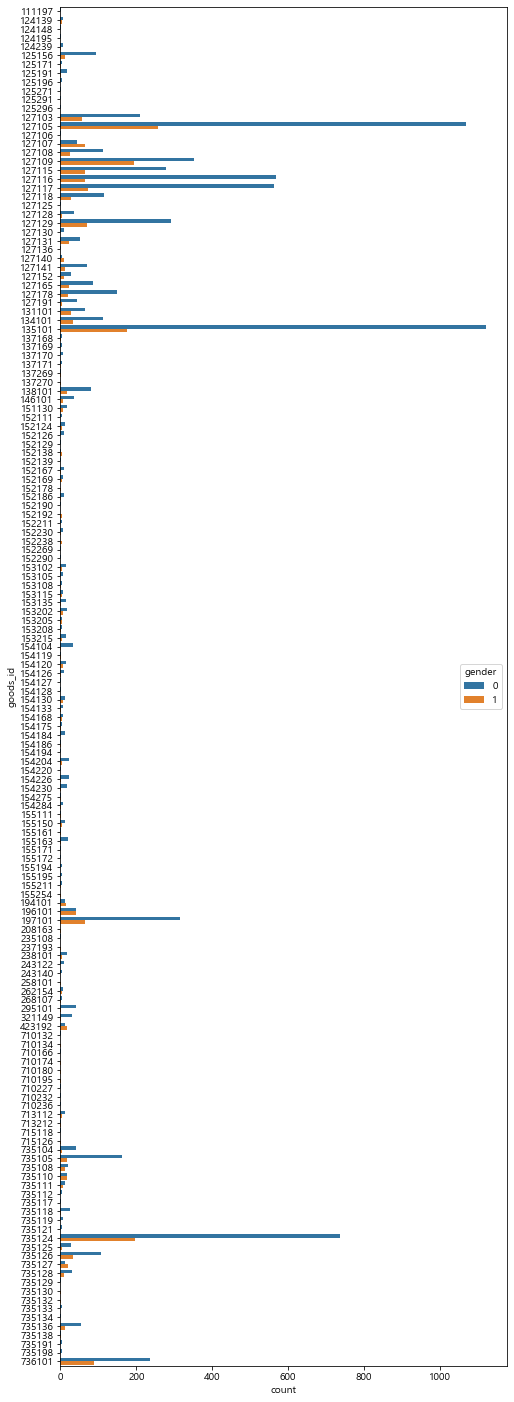

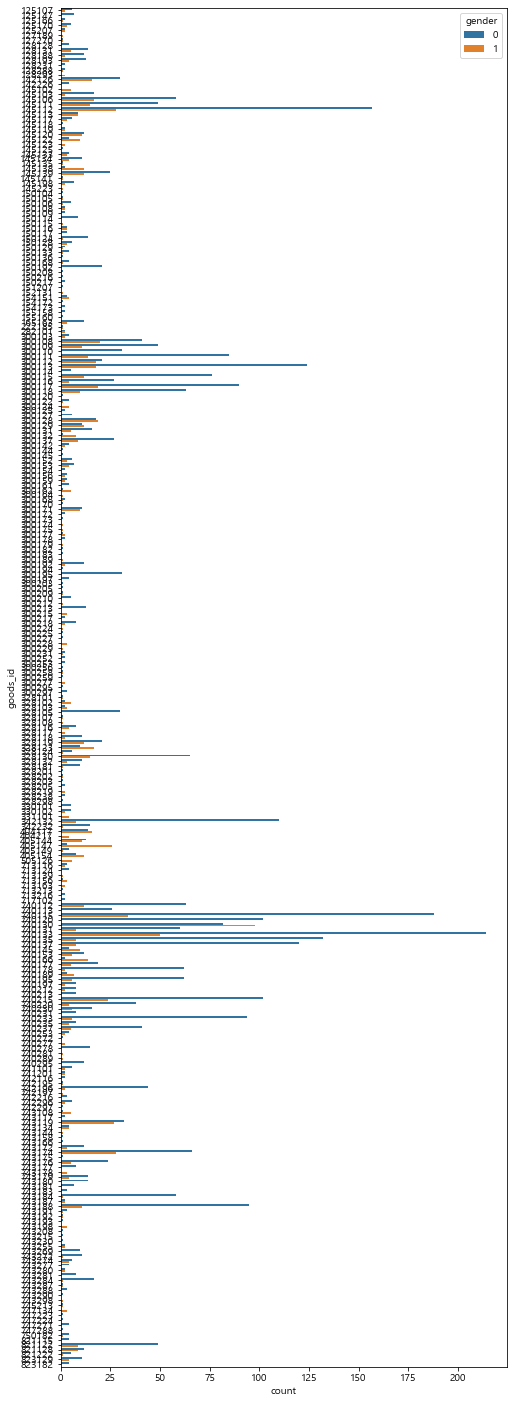

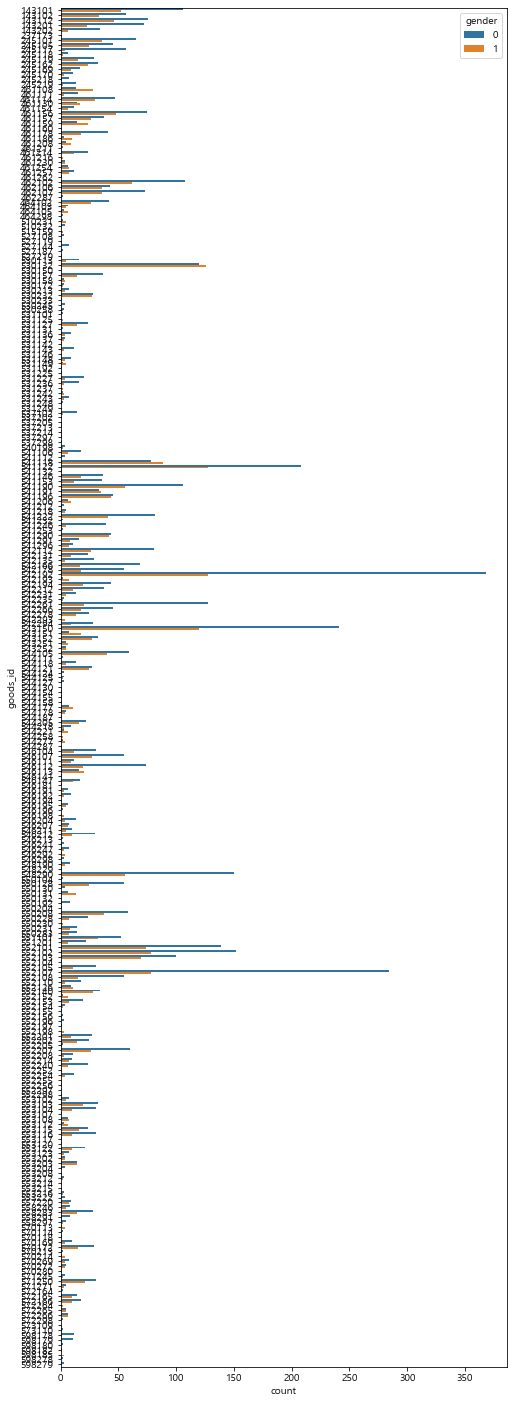

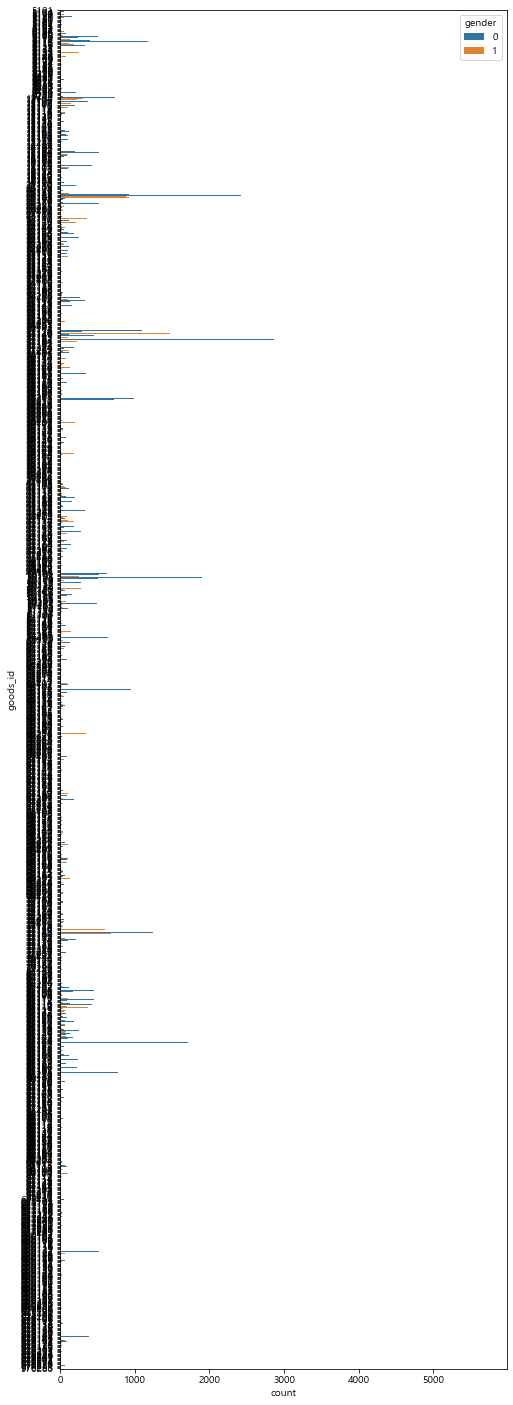

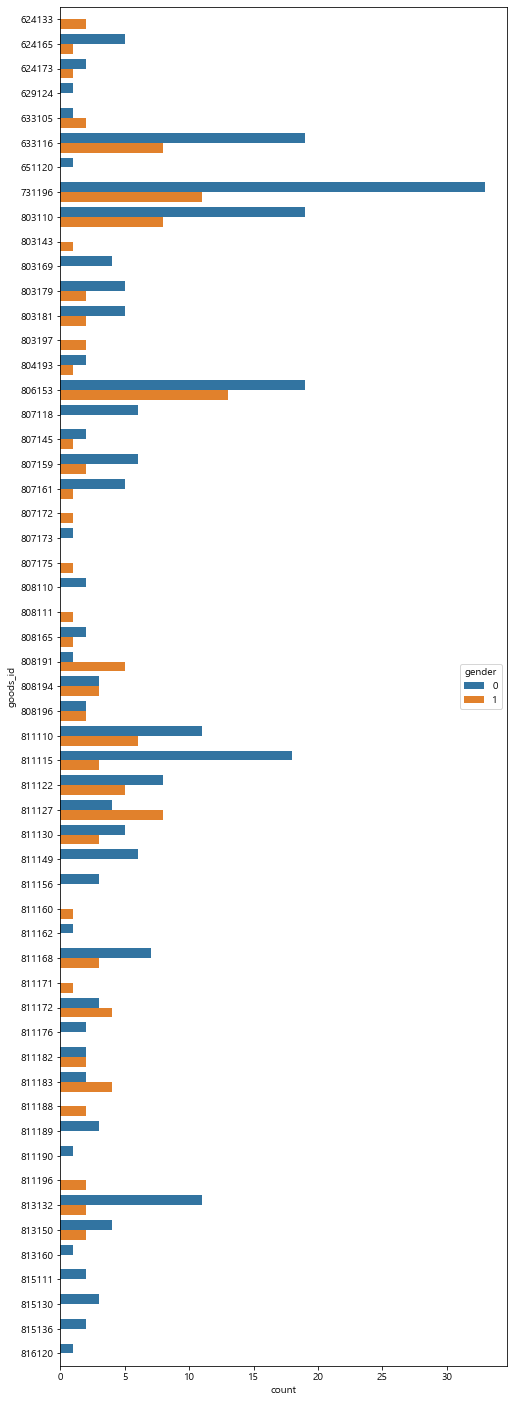

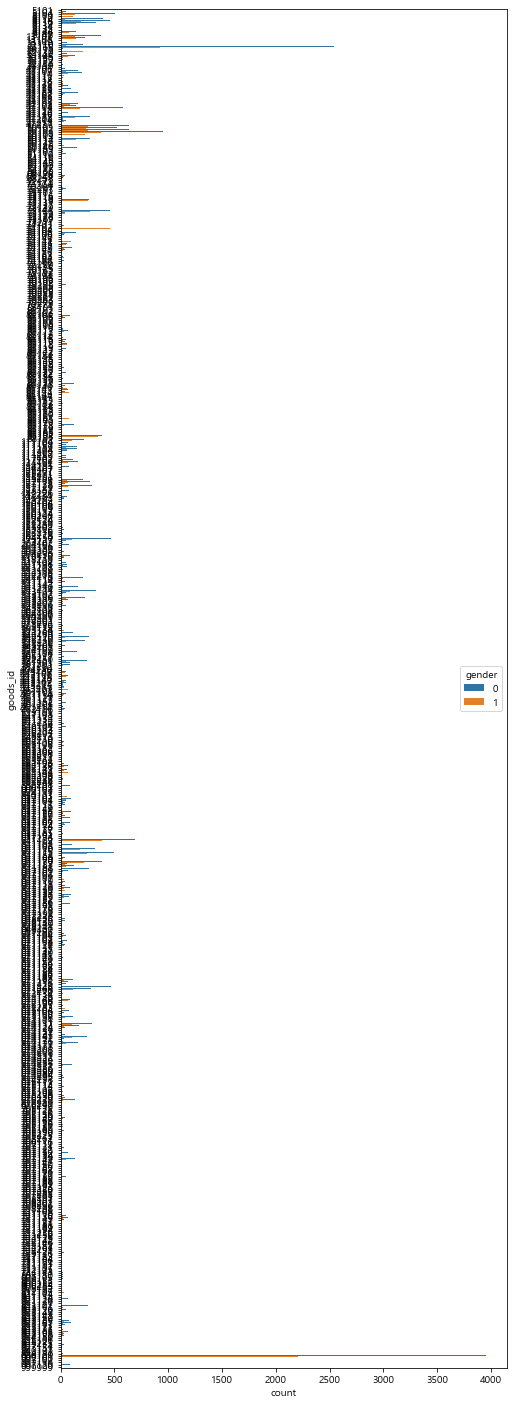

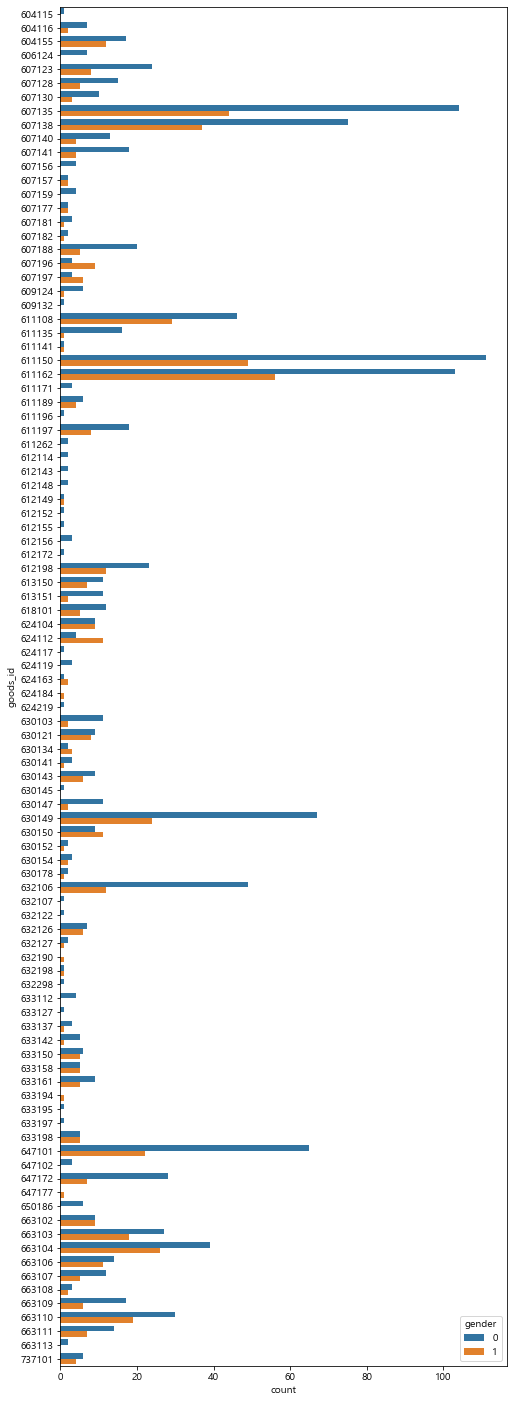

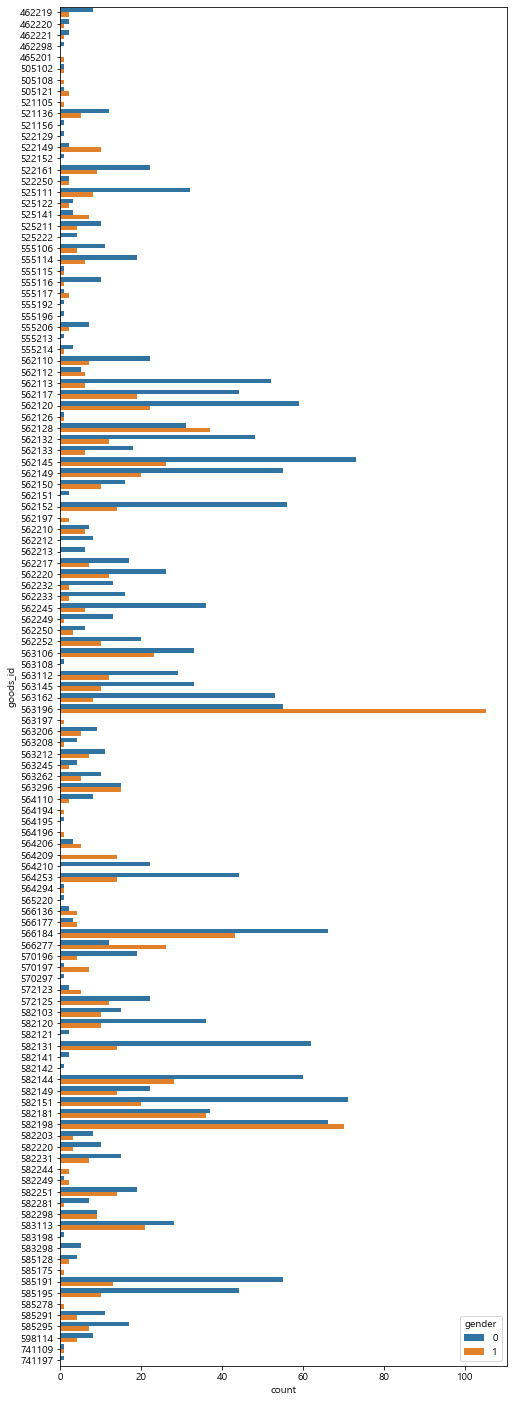

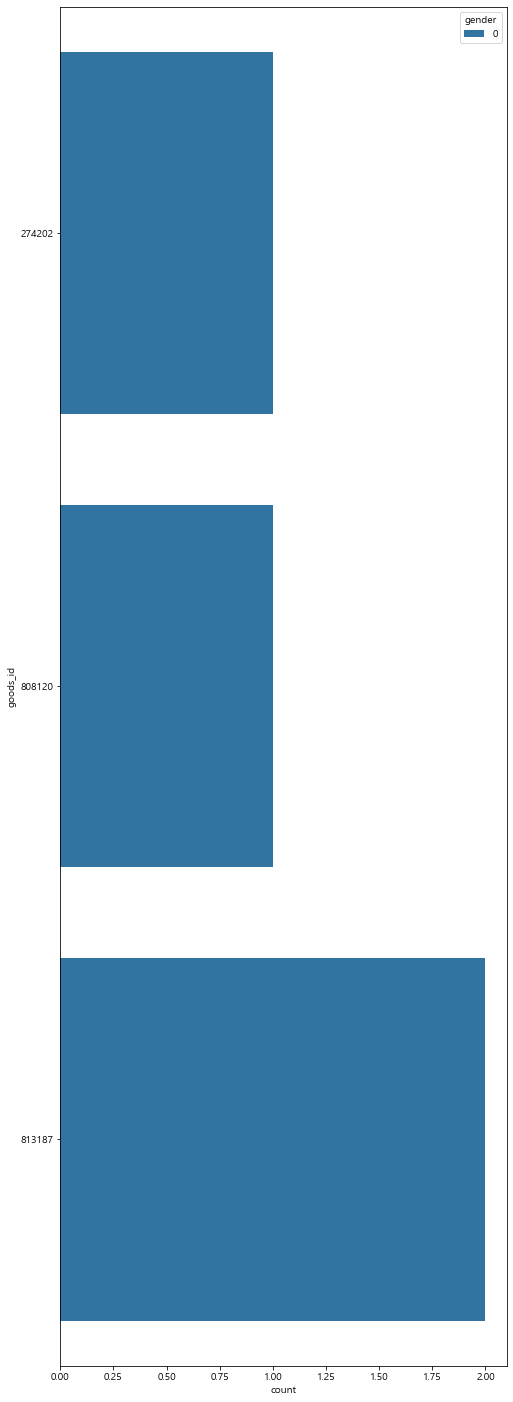

In [95]:
plt.rcParams['figure.figsize'] = [8, 25] # [width, height] (inches)
for mclas in all_mclas:
    
    display(sns.countplot(data=tr.query(f'gds_grp_mclas_nm in {mclas}'), y='goods_id', hue='gender'))
    plt.show()

### 4. goods_id에서 남성이 여성보다 더 많이 구매한 물품목록 뽑아내기

   - 남성이 여성보다 구매를 더 많이하면서, 남성이 3회이상 구매한 물품목록을 뽑아내었다
        - 위 조건에 해당하는 goods_id는 313개의 물품이 나왔다

In [96]:
temp_goodsdf = pd.pivot_table(tr, index = 'goods_id', columns='gender', values='amount', aggfunc=np.size, fill_value=0)

temp_goodsdf = temp_goodsdf.rename(columns={0:'women',1:'men'})

temp_goodsdf.query('men > women and men > 2')[:15]

gender    women  men
goods_id            
5130         26   52
6163          2    3
6188          0    8
8134          4    8
8144          6   12
8190         13   36
8290          0    3
13109         0   20
13114         7   12
14198         5    8
26285        37   49
26290        30   34
33142         0    4
33288         1    3
34112         2    3

In [97]:
# 남성이 더 구매경향을 보이는 goods_id 상품들을 리스트로 뽑아내었다

men_tendency_product = temp_goodsdf.query('men > women and men > 2').index.tolist()

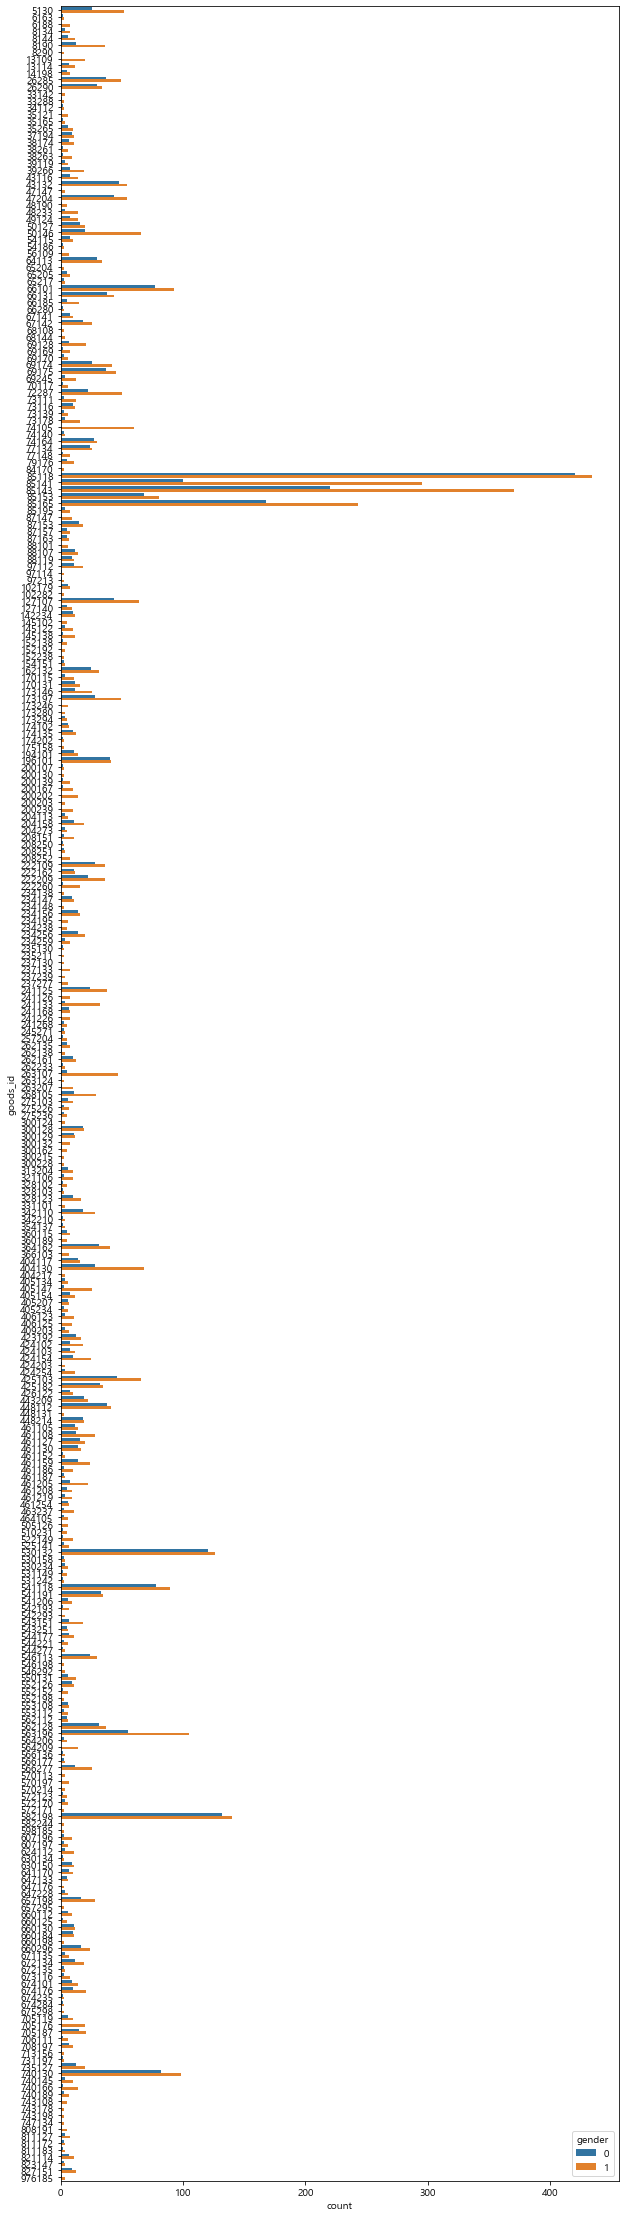

In [98]:
plt.rcParams['figure.figsize'] = [10, 40] # [width, height] (inches)
sns.countplot(data=tr.query('goods_id in @men_tendency_product'), y='goods_id', hue='gender')
plt.show()

### 5. 뽑아낸 물품목록으로 피쳐 생성하기

    - 0. tr2에서도 이에 해당하는 물품들을 뽑아내고 교집합물품들을 뽑아낸다 -> men_tendency_intersection
    - 1. men_tendency_product에 해당하는 goods_id를 구매하였는지 구매여부
    - 2. men_tendency_product의 구매건수

0. tr2에서도 조건에 해당하는 물품을 뽑아서 교집합하기

In [99]:
men_tendency_product2 = []

for goods_id in men_tendency_product:
    
    if goods_id in tr2.goods_id.unique():
        
        men_tendency_product2.append(goods_id)

In [100]:
# 교집합 품목을 뽑아낸다.
men_tendency_intersection = list(set(men_tendency_product).intersection(men_tendency_product2))

print('교집합 갯수: ', len(men_tendency_intersection))

교집합 갯수:  278


1. 구매여부 -> 구매하였을 경우 10을 주었다

In [101]:
for i in trs:

    temp_goodsdf = pd.pivot_table(i.query('goods_id in @men_tendency_intersection'), index='cust_id', columns='goods_id', values='amount', aggfunc=np.size, fill_value=0)

# 모든 원소에 대해서 만약 원소가 0보다 크다면 10을 주었다 -> (구매안함: 0, 구매함: 10)
    temp_goodsdf = temp_goodsdf = temp_goodsdf.applymap(lambda x : 10 if x>0 else 0)

# 칼럼명 변경(겹치지 않도록)
    origin_name = temp_goodsdf.columns.tolist()
    new_name = [str(i)+'_M_tenden_isbuy' for i in origin_name]
    temp_goodsdf = temp_goodsdf.rename(columns=dict(zip(origin_name, new_name)))
    
    temp_goodsdf = temp_goodsdf.reset_index()

# nan값 제거    
    if len(i) == 232004:
        merge_temp = pd.DataFrame({'cust_id':[i for i in range(3500)]})
    else:
        merge_temp = pd.DataFrame({'cust_id':[i for i in range(3500, 5982)]})
    f = pd.merge(merge_temp, temp_goodsdf, how='outer').fillna(0).astype(int)
    features.append(f); f

## ch.2

### 1. 남성만 혹은 여성만 구매하는 제품을 조사

   - 남성들만 혹은 여성들만 구매한 제품군들이 있음을 확인
        - 데이터 불균형을 해소하고자 남성을 구분할 수 있도록 남성들만 쓰는 제품들을 살펴보았으나 goods_id까지 봤지만 데이터가 600여개로 너무 적었음
        - 이에 차라리 데이터가 많은 여성측에서 여성경향이 강한 제품들로 여성을 구분하고자 함

In [102]:
print("---- 전체 ----")

print('대분류: ', tr.gds_grp_mclas_nm.nunique())

print('중분류: ', tr.gds_grp_nm.nunique())

print('소분류: ', tr.goods_id.nunique())

print('\n\n---- 남성 ----')

print('대분류: ', tr.query('gender == 1').gds_grp_mclas_nm.nunique())

print('중분류: ', tr.query('gender == 1').gds_grp_nm.nunique())

print('소분류: ', tr.query('gender == 1').goods_id.nunique())

print('\n\n---- 여성 ----')

print('대분류: ', tr.query('gender == 0').gds_grp_mclas_nm.nunique())

print('중분류: ',tr.query('gender == 0').gds_grp_nm.nunique())

print('소분류: ',tr.query('gender == 0').goods_id.nunique())

---- 전체 ----
대분류:  49
중분류:  324
소분류:  3471


---- 남성 ----
대분류:  46
중분류:  308
소분류:  2618


---- 여성 ----
대분류:  49
중분류:  315
소분류:  3200


## 2. 여성만 쓰는 제품목록 뽑아내기

 - 여성들만 구매하는 제품목록을 대분류 -> 중분류 -> 소분류 순으로 살펴본 결과 대분류, 중분류만으로는 데이터가 너무 적어 구분하기 어렵다고 판단
 - 여성들만 구매하는 소분류(goods_id)제품들을 리스트로 뽑아내었음
     - 조건1: 여성들만 구매
     - 조건2: 여성들이 적어도 3회 이상 구매
     - 조건3: 여성들이 적어도 3명 이상 구매
 - 조건을 모두 만족시키는 제품군을 뽑아서 여성을 구분하는 피쳐를 만들고자 함

조건1

In [103]:
w_use_goods = tr.query('gender == 0').goods_id.unique().tolist()

m_use_goods = tr.query('gender == 1').goods_id.unique().tolist()

all_use_goods = tr.goods_id.unique().tolist()

In [104]:
w_goods = []
for goods in all_use_goods:
     if goods not in m_use_goods:
            w_goods.append(goods)

print('\n여성의 수: ',tr.query('gender == 0').cust_id.nunique())
print('\n여성경향 물품을 구매한 여성 수: ', tr.query('goods_id in @w_goods')['cust_id'].nunique())
print(f'\n여성경향 물품을 구매한 여성 비율: {788 / 2184:.4}')

print('\n여성들만 쓰는 제품수: ', len(w_goods))


여성의 수:  2184

여성경향 물품을 구매한 여성 수:  788

여성경향 물품을 구매한 여성 비율: 0.3608

여성들만 쓰는 제품수:  853


조건2 와 조건3

In [105]:
w_buymorethan3df = tr.query('gender == 0').groupby('cust_id')['goods_id'].value_counts().rename().reset_index().rename(columns={0:'count'})

w_buymorethan3lst = w_buymorethan3df.query('count >= 3').goods_id.unique().tolist()

print('여성들이 3회이상 구매한 물품 목록 수: ', len(w_buymorethan3lst))

w_goodsdf = tr.query('gender == 0').goods_id.value_counts().reset_index().query('goods_id>=3').rename(columns={'index':'goods_id','goods_id':'count'})

w_morethan3pplbuy = w_goodsdf.goods_id.unique().tolist()

print('\n여성들이 3명이상 구매한 물품 목록 수: ', len(w_morethan3pplbuy))

여성들이 3회이상 구매한 물품 목록 수:  1511

여성들이 3명이상 구매한 물품 목록 수:  2367


조건 1,2,3을 모두 만족하는 물품목록(여성만 구매, 여성이 3회이상 구매, 여성이 3명이상 구매)

In [106]:
# 조건1과 조건2 교집합
con1AndCon2 = set(w_goods).intersection(w_buymorethan3lst)

# 교집합된 목록과 조건3의 교집합
w_tendency_product = list(con1AndCon2.intersection(w_morethan3pplbuy))

print('교집합된 물품 목록 수: ', len(w_tendency_product))

교집합된 물품 목록 수:  155


##  3. 뽑아낸 물품목록으로 피쳐 생성하기

 - test데이터도 같은 과정을 거쳐 피쳐를 생성해야하나 gender가 없기 때문에 test데이터의 goods_id와 교집합
 - 둘다 만족하는 최종 w_tendency_product를 토대로 피쳐생성
     - 1. 여성경향 물품 구매건수
     - 2. 여성경향 물품 구매여부

In [107]:
# test데이터의 goods_id 목록
tr2_goodslst = tr2.goods_id.unique().tolist()

# test데이터에도 존재하는 여성경향 몰품 목록 찾기
final_w_tendency_product = []
for product in w_tendency_product:
    
    if product in tr2_goodslst:
        
        final_w_tendency_product.append(product)

# 최종 여성경향 물품목록 추출
print(final_w_tendency_product)
print()
print('개수: ', len(final_w_tendency_product))

[262148, 72204, 221206, 47127, 731171, 562212, 5160, 262189, 303153, 303158, 88120, 88123, 152126, 26179, 67148, 300110, 322128, 641106, 300114, 66136, 87132, 300127, 150114, 257124, 67173, 364135, 43126, 303225, 64124, 364158, 85119, 342143, 322176, 404102, 66186, 85131, 660108, 660106, 85134, 175257, 300195, 85155, 342181, 85160, 300213, 85181, 173245, 303295, 233152, 85187, 807118, 275156, 321247, 84192, 637155, 235243, 423154, 550130, 976118, 43267, 38151, 743177, 191242, 743180, 743181, 740113, 234262, 740120, 274202, 84279, 34106, 16195, 204112, 35152, 674137, 54106, 54110, 38245, 33126, 743281, 354167, 823159, 77178, 821115, 33150, 352130, 54146, 821126, 976263, 740231, 32138, 248198, 165260, 73102, 38287, 676240, 164252, 74147, 546213, 671146, 79273, 461227, 33198, 35247, 671152, 243122, 461234, 740278, 243140, 8135, 740295, 222154, 650186, 35287, 564210, 8183, 8186]

개수:  117


이러한 물품을 구매한 여성의 비율

In [108]:
print('전체 여성 수:', tr.query('gender == 0').cust_id.nunique())

print('\n여성 경향 물품을 구매한 여성 수:', tr.query('goods_id in @final_w_tendency_product').cust_id.nunique())

print(f'\n여성 경향 물품을 구매한 여성의 비율: {350/2184:.4}')

전체 여성 수: 2184

여성 경향 물품을 구매한 여성 수: 350

여성 경향 물품을 구매한 여성의 비율: 0.1603


2. 여성경향 물품 구매여부

In [109]:
for i in trs:

    w_tempdf = pd.pivot_table(i.query('goods_id in @final_w_tendency_product'), index='cust_id', columns='goods_id', values='amount', aggfunc=np.size, fill_value=0)

# 구매여부 조건: 샀을경우 20 아니면 0
    w_tempdf = w_tempdf.applymap(lambda x: 20 if x > 0 else 0)

    origin = w_tempdf.columns.tolist()
    new_name = [str(i)+'_w_ten_isbuy' for i in range(len(origin))]
    w_tempdf = w_tempdf.rename(columns=dict(zip(origin, new_name)))

    if len(i) == 232004:
        merge_temp = pd.DataFrame({'cust_id':[i for i in range(3500)]})
    else:
        merge_temp = pd.DataFrame({'cust_id':[i for i in range(3500,5982)]})

    w_tempdf = w_tempdf.reset_index()

    f = pd.merge(merge_temp, w_tempdf, how='outer').fillna(0)
    features.append(f); f

### Merge & Save Features


In [110]:
for i in features:
    if len(i) == 3500:
        features1.append(i)
    else:
        features2.append(i)
print(len(features1))
print(len(features2))

both_features = [features1, features2]

35
35


In [111]:
data = pd.DataFrame({'cust_id': tr.cust_id.unique()})
for f in features1 :
    data = pd.merge(data, f, how='left')
display(data)
data.to_csv('X_train_after_eda.csv', index=False, encoding='cp949')
data.info()

cust_id  class total_amount_range2 purchase_count  \
0           0    600                   6             80   
1           1    100                   0             10   
2           2    100                   0             10   
3           3    300                   1             50   
4           4    400                   2             10   
...       ...    ...                 ...            ...   
3495     3495    100                   0             10   
3496     3496    400                   2             20   
3497     3497    100                   0             10   
3498     3498    100                   0             10   
3499     3499    700                  26            100   

     total_amount_avg_range1 max_amount_range2  per_visit_pur_num  \
0                          9                 2                  4   
1                          7                 1                  2   
2                          7                 1                  2   
3                          3                 1                  2   
4                         96                 3                  2   
...                      ...               ...                ...   
3495                      15                 1                  2   
3496                      22                 1                  2   
3497                       0                 1                  1   
3498                       9                 1                  1   
3499                      28                 4                  2   

     total_visit2 buying_cycle2  perfer_season  spring_pur_ratio  \
0               9             8              1          0.094595   
1               0             0              2          0.000000   
2               0             0              3          0.000000   
3               8             7              0          0.590909   
4               0            42              2          0.333333   
...           ...           ...            ...               ...   
3495            0             0              1          0.000000   
3496            3            19              2          0.076923   
3497            0             0              3          0.000000   
3498            0            19              0          0.500000   
3499           18             3              1          0.271739   

      summer_pur_ratio  fall_pur_ratio  winter_pur_ratio  prefer_month  \
0             0.391892        0.378378          0.135135            10   
1             0.000000        1.000000          0.000000            10   
2             0.000000        0.000000          1.000000             1   
3             0.159091        0.113636          0.136364             3   
4             0.000000        0.666667          0.000000            11   
...                ...             ...               ...           ...   
3495          1.000000        0.000000          0.000000             6   
3496          0.076923        0.461538          0.384615            12   
3497          0.000000        0.000000          1.000000             1   
3498          0.000000        0.000000          0.500000             1   
3499          0.326087        0.260870          0.141304             6   

      1_month_amount  2_month_amount  9_month_amount  0to10_visits  \
0           0.012448        0.000000        0.027163      0.421053   
1           0.000000        0.000000        0.000000      0.000000   
2           1.000000        0.000000        0.000000      1.000000   
3           0.000000        0.309934        0.028831      0.333333   
4           0.000000        0.000000        0.000000      0.000000   
...              ...             ...             ...           ...   
3495        0.000000        0.000000        0.000000      0.000000   
3496        0.000000        0.243008        0.060836      0.500000   
3497        1.000000        0.000000        0.000000      1.000000   
3498        0.466667        0.000000        0.000000      0.50

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3500 entries, 0 to 3499
Columns: 1644 entries, cust_id to 116_w_ten_isbuy
dtypes: category(43), float64(1302), int32(278), int64(21)
memory usage: 39.4 MB


In [112]:
data = pd.DataFrame({'cust_id': tr2.cust_id.unique()})
for f in features2 :
    data = pd.merge(data, f, how='left')
display(data)
data.to_csv('X_test_after_eda.csv', index=False, encoding='cp949')
data.info()

cust_id  class total_amount_range2 purchase_count  \
0        3500    600                   7             20   
1        3501    700                  31            210   
2        3502    700                  30            290   
3        3503    200                   0             10   
4        3504    100                   0             10   
...       ...    ...                 ...            ...   
2477     5977    600                   8             20   
2478     5978    100                   0             10   
2479     5979    700                  26             80   
2480     5980    600                   8             20   
2481     5981    100                   0             10   

     total_amount_avg_range1 max_amount_range2  per_visit_pur_num  \
0                         37                 3                  1   
1                         14                 4                  2   
2                          2                 2                 15   
3                          7                 1                  2   
4                          2                 1                  3   
...                      ...               ...                ...   
2477                      58                 3                  2   
2478                       4                 1                  1   
2479                      36                 3                  4   
2480                      49                 2                  4   
2481                       0                 1                  5   

     total_visit2 buying_cycle2  perfer_season  spring_pur_ratio  \
0               6            12              3          0.210526   
1              44             1              2          0.091324   
2              50             1              1          0.233582   
3               2            23              3          0.100000   
4               1             3              3          0.000000   
...           ...           ...            ...               ...   
2477            3            19              3          0.071429   
2478            0             0              3          0.000000   
2479            9             8              3          0.154930   
2480            2            29              0          0.277778   
2481            0            15              3          0.100000   

      summer_pur_ratio  fall_pur_ratio  winter_pur_ratio  prefer_month  \
0             0.052632        0.157895          0.578947            12   
1             0.356164        0.410959          0.141553            11   
2             0.283683        0.243737          0.238998             1   
3             0.100000        0.000000          0.800000             1   
4             0.000000        0.000000          1.000000             1   
...                ...             ...               ...           ...   
2477          0.285714        0.285714          0.357143             1   
2478          0.000000        0.000000          1.000000             1   
2479          0.225352        0.154930          0.464789             1   
2480          0.166667        0.277778          0.277778             9   
2481          0.000000        0.000000          0.900000             1   

      1_month_amount  2_month_amount  9_month_amount  0to10_visits  \
0           0.044287        0.000000        0.047272      0.307692   
1           0.000000        0.000000        0.106956      0.377778   
2           0.136482        0.043475        0.090551      0.366337   
3           0.959969        0.000000        0.000000      0.600000   
4           0.214162        0.785838        0.000000      0.333333   
...              ...             ...             ...           ...   
2477        0.314211        0.000000        0.000000      0.750000   
2478        1.000000        0.000000        0.000000      0.000000   
2479        0.206069        0.005192        0.105641      0.263158   
2480        0.000000        0.349863        0.205803      0.60

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2482 entries, 0 to 2481
Columns: 1644 entries, cust_id to 116_w_ten_isbuy
dtypes: category(43), float64(1302), int32(278), int64(21)
memory usage: 28.0 MB


## ────────────────────────────────────────────────────────

###  피쳐 상관관계

#### 1차 피쳐 상관관계

<font color = 'blue'> EDA 이후 채택되지 않은 피쳐들 제거

가격: 가격 선호도, 환불금액, 환불건수, 내점 당 구매액,      
시간: 월별 방문비율, 월별 구매건수, 월초, 월중, 월말 선호 방문때, 최근 3개월, 6개월, 12개월 구매금&구매건수   
장소: 주구매지점   
제품: Top-10 베스트 셀러(gds_grp_mclas_nm)에 대한 구매 금액/건수/여부(겹쳐서)   
기타: 휴면(또는 이탈)여부 

<font color = 'blue'> 같은 관점의 피쳐끼리 상관관계
    - 같은 관점끼리 히트맵을 그려 상관관계가 0.7이상인 칼럼들을 모두 제거하였다
    - 밑의 히트맵은 상관관계가 높았던 칼럼들의 제거 이후에 그린 히트맵이다

상관관계가 0.7이상으로 높아서 삭제한 칼럼들   


가격: none   
시간: 월초, 월중, 월말 구매건수&구매비율, 요일별 구매건수, 주말 구매건수, 1월 구매비율, 수목금 구매비율   
장소: top12 방문비율   
제품: 소중대분류에서 상관관계 높은 상품 162개   
기타: none


In [113]:
df = pd.read_csv('X_train_after_eda.csv', encoding='cp949')
X_test = pd.read_csv('X_test_after_eda.csv', encoding='cp949')

In [114]:
high_corr_cols = []

delCol1 = ['0to10_10unit', '11to20_20unit', '21to31_30unit','4_buy', '3_buy', '2_buy','0_buy','6_buy','5_buy','1_buy','weekend_buy2', '1_month_amount','2_month_amount','0to10_amount','0to10_amount','11to20_20unit','21to31_amount','3_amount','2_amount','4_amount']

delCol2 = ['0_visits0','1_visits1','2_visits2','3_visits3','4_visits4','5_visits5','6_visits6','7_visits7','8_visits8','9_visits9','10_visits10']

delCol3 = ['num_pur_type2', 'num_pur_type3']

delCol4 = ['241192', '262241', '263107', '542166', '740195', '742196', '241125_buy', '241133_buy', '241192_buy', '262141_buy', '262241_buy', '263107_buy', '342111_buy', '342132_buy', '562128_buy', '563196_buy', '740195_buy', '742196_buy', '96grp_nm_buy', '141grp_nm_buy', '165grp_nm_buy', '189grp_nm_buy', '195grp_nm_buy', '18mclas_nm_buy', '48mclas_nm_buy', '63mclas_nm_buy', '56108', '607138', '811110', '66123_buy', '77152_buy', '303126_buy', '321103_buy', '542192_buy', '607138_buy', '39grp_nm', '45grp_nm', '192grp_nm', '12grp_nm_buy', '15grp_nm_buy', '36grp_nm_buy', '45grp_nm_buy', '111grp_nm_buy', '3mclas_nm', '15mclas_nm', '15mclas_nm_buy', '21mclas_nm_buy', '45mclas_nm_buy', '26165', '66123', '68273', '73119', '125156', '127118', '127128', '127131', '127141', '128128', '128131', '173197', '204125', '204128', '204152', '204162', '206101', '208102', '208110', '208121', '208140', '222102', '245105', '245117', '245140', '261188', '275131','303125', '303140', '321106', '322103', '322154', '322158', '331101', '342150', '361106', '361206', '365219', '530157', '530232', '541153', '542266', '552110', '562117', '562132', '563112', '611150', '611162', '611189', '613151', '624165', '630134', '647101','663102', '663106', '663108', '663110', '663111', '735105', '735124', '737101', '740112', '740120', '740130', '740131', '740153', '740177', '740178', '740215', '808194', '811115', '811127', '811156', '813150', '823165', '37140_buy', '56108_buy', '73151_buy', '127109_buy', '262161_buy', '303109_buy', '303110_buy', '303146_buy', '303209_buy', '303246_buy', '322111_buy', '322211_buy', '562113_buy', '611150_buy', '618101_buy', '647101_buy', '663106_buy', '731196_buy', '735124_buy', '9grp_nm', '42grp_nm', '54grp_nm', '72grp_nm', '78grp_nm', '93grp_nm', '135grp_nm', '198grp_nm', '42grp_nm_buy', '54grp_nm_buy', '72grp_nm_buy', '78grp_nm_buy', '93grp_nm_buy', '108grp_nm_buy', '117grp_nm_buy', '135grp_nm_buy', '138grp_nm_buy', '171grp_nm_buy', '192grp_nm_buy', '198grp_nm_buy']

delCol5 = ['8134_M_tenden_isbuy', '13109_M_tenden_isbuy', '87147_M_tenden_isbuy', '200202_M_tenden_isbuy', '200239_M_tenden_isbuy', '263107_M_tenden_isbuy', '263207_M_tenden_isbuy', '300215_M_tenden_isbuy', '300228_M_tenden_isbuy', '598185_M_tenden_isbuy', '647176_M_tenden_isbuy', '705176_M_tenden_isbuy', '713156_M_tenden_isbuy']

delCol6 = ['9_w_ten_isbuy', '14_w_ten_isbuy', '39_w_ten_isbuy', '56_w_ten_isbuy', '90_w_ten_isbuy']

high_corr_cols = delCol1 + delCol2 + delCol3 + delCol4 + delCol5 + delCol6

print('1차 상관관계 높은 칼럼 제거 개수: ', len(high_corr_cols))

df2 = df.drop(columns=high_corr_cols)

1차 상관관계 높은 칼럼 제거 개수:  213


In [115]:
df.loc[:,'69mclas_nm_buy':]

69mclas_nm_buy  5130_M_tenden_isbuy  6163_M_tenden_isbuy  \
0                7.0                    0                    0   
1                0.0                    0                    0   
2                0.0                    0                    0   
3                0.0                    0                    0   
4                1.0                    0                    0   
...              ...                  ...                  ...   
3495             0.0                    0                    0   
3496             0.0                    0                    0   
3497             0.0                    0                    0   
3498             2.0                    0                    0   
3499             8.0                    0                    0   

      6188_M_tenden_isbuy  8134_M_tenden_isbuy  8144_M_tenden_isbuy  \
0                       0                    0                    0   
1                       0                    0                    0   
2                       0                    0                    0   
3                       0                    0                    0   
4                       0                    0                    0   
...                   ...                  ...                  ...   
3495                    0                    0                    0   
3496                    0                    0                    0   
3497                    0                    0                    0   
3498                    0                    0                    0   
3499                    0                    0                    0   

      8290_M_tenden_isbuy  13109_M_tenden_isbuy  13114_M_tenden_isbuy  \
0                       0                     0                     0   
1                       0                     0                     0   
2                       0                     0                     0   
3                       0                     0                     0   
4                       0                     0                     0   
...                   ...                   ...                   ...   
3495                    0                     0                     0   
3496                    0                     0                     0   
3497                    0                     0                     0   
3498                    0                     0                     0   
3499                    0                     0                     0   

      14198_M_tenden_isbuy  26285_M_tenden_isbuy  26290_M_tenden_isbuy  \
0                        0                     0                     0   
1                        0                     0                     0   
2                        0                     0                     0   
3                        0                     0                     0   
4                        0                     0                     0   
...                    ...                   ...                   ...   
3495                     0                     0                     0   
3496                     0                     0                     0   
3497                     0                     0                     0   
3498                     0                     0                     0   
3499                     0                     0                     0   

      33288_M_tenden_isbuy  34112_M_tenden_isbuy  35165_M_tenden_isbuy  \
0                        0                     0                     0   
1                        0                     0                     0   
2                        0                     0                     0   
3                        0                     0                     0   
4                        0                     0                     0   
...                    ...                   ...                   ...   
3495                     0                     0                     0   
34

In [116]:
df = df.drop('cust_id', axis=1)

price_df = df.iloc[:, :6]

time_df = df.loc[:,'total_visit2':'weekend_buy2']
time_df = time_df.drop(columns=delCol1)

store_df = df.loc[:,'stores_count':'10_amount_ratio10']
store_df = store_df.drop(columns=delCol2)

product_df = df.loc[:,'main_product_goods':'num_pur_type3']
product_df = product_df.drop(columns=delCol3)

product_df2 = df.loc[:,'13104':'69mclas_nm_buy']
product_df2 = product_df2.drop(columns=delCol4)

M_product = df.loc[:,'5130_M_tenden_isbuy':'976185_M_tenden_isbuy']
M_product = M_product.drop(columns=delCol5)

W_product = df.loc[:,'0_w_ten_isbuy':]
W_product = W_product.drop(columns=delCol6)

<font color = 'blue'> 모든 피쳐끼리 상관관계 
    - 마지막으로 모든 피쳐중 높은 상관관계를 갖는 것으로 보이는 칼럼제거
    - 칼럼 제거이후 1000개가 넘는 피쳐끼리 상관관계가 0.7이상으로 높은 피쳐는 없었음

In [117]:
highcorr = ['purchase_count','total_visit2', '13114_M_tenden_isbuy', '68144_M_tenden_isbuy', '196101_M_tenden_isbuy', '222109_M_tenden_isbuy', '241133_M_tenden_isbuy', '321106_M_tenden_isbuy', '331101_M_tenden_isbuy', '342110_M_tenden_isbuy', '404130_M_tenden_isbuy', '425103_M_tenden_isbuy', '425182_M_tenden_isbuy', '448112_M_tenden_isbuy', '461108_M_tenden_isbuy', '541118_M_tenden_isbuy', '541191_M_tenden_isbuy', '630134_M_tenden_isbuy', '630150_M_tenden_isbuy', '811127_M_tenden_isbuy', '62_w_ten_isbuy', '114_w_ten_isbuy','6_num_of_pur6', '10_num_of_pur10', '37183_buy', '37194_M_tenden_isbuy']


df3 = df2.drop(columns=highcorr)


In [118]:
corrdf = (df3.corr() >= 0.7).sum().reset_index().rename(columns={'index':'cols',0:'corrCount'})

corrlst = corrdf.query('corrCount > 1')['cols'].unique().tolist()

In [119]:
len(corrlst)

0

In [120]:
cols = df3.columns.tolist()
X_test = X_test[cols]

In [121]:
df3.to_csv('X_train_after_corr.csv',index=False, encoding='cp949')
X_test.to_csv('X_test_after_corr.csv', index=False, encoding='cp949')

## ────────────────────────────────────────────────────────

###  피쳐 전처리

#### 피쳐 전처리
 - 이상치 제거
 - 로그변환
 - MinMaxScaling
 - PCA
 - Select Features

In [122]:
# 추가 라이브러리
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import LogisticRegression
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler

In [123]:
X_train = pd.read_csv('X_train_after_corr.csv',encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
X_test = pd.read_csv('X_test_after_corr.csv', encoding='cp949')
IDtest = X_test.cust_id.unique()

train_test = pd.concat([X_train, X_test], ignore_index=True)


<font color = 'blue'> 이상치 제거

In [124]:
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.03), x.quantile(.93)), axis=0)

<font color = 'blue'> 로그변환

In [125]:
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

<font color = 'blue'> MinMaxScaling

In [126]:
X_train = train_test[:3500]
X_test = train_test[3500:]

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

train_test = pd.concat([X_train, X_test], ignore_index=True)

<font color = 'blue'> PCA

In [127]:
max_col = train_test.shape[1]
pca = PCA(n_components=max_col, random_state=0).fit(train_test)

cumsum = np.cumsum(pca.explained_variance_ratio_)
num_col = np.argmax(cumsum >= 0.99) + 1

# num_col 이 1이었기 때문에 num_col은 max_col이 되었다

if num_col == 1:
    num_col = max_col

pca = PCA(n_components = num_col, random_state=0).fit_transform(train_test)
train_test = pd.DataFrame(pca)

In [128]:
X_train = train_test[:3500]
X_test = train_test[3500:]

In [129]:
X_train

0         1         2         3         4         5         6    \
0     1.179937 -0.513716 -0.346977 -0.801680  0.282436 -0.724435 -0.491337   
1    -1.268855 -0.076007  0.032100  0.521487 -0.068972  0.552444 -0.280855   
2    -1.563934  0.192501 -0.110080  0.224069  0.238145  0.813171  0.002670   
3     0.301574  1.532150 -0.732102  0.495843 -0.286790  0.244413 -0.160716   
4    -1.165795 -0.078869  0.473760 -0.375914 -0.114924  0.268367 -0.046016   
...        ...       ...       ...       ...       ...       ...       ...   
3495 -1.355229 -0.035930  0.361450  0.558096  0.301034 -0.381079  0.518088   
3496 -0.639538 -0.606698 -0.974931 -0.259834  0.109699 -0.732402  0.437411   
3497 -1.917465  0.141244  0.087366  0.223084 -0.106564  0.936743  0.159031   
3498 -1.528305  0.029988  0.547995 -0.376681 -0.548651  0.510579 -0.180379   
3499  2.023887 -1.124327  0.345880 -0.535084  0.304055 -0.474908 -0.224325   

           7         8         9         10        11        12        13   \
0    -1.200347  0.947870 -0.016796  0.433116 -0.258911 -0.778575 -0.889530   
1    -0.601969  0.344403  0.608123  0.239330  0.315379 -0.206365  0.327947   
2    -0.538691  0.677558  0.371626 -0.065097 -0.158805 -0.343140  0.362344   
3     0.197900  1.103240  0.034801  0.327107  0.000662  0.883000  0.360259   
4    -0.883312  0.452892  0.536467  0.181252 -0.167922  0.095422  0.382142   
...        ...       ...       ...       ...       ...       ...       ...   
3495  0.047575  0.252481 -0.221469  0.449457 -0.239708 -0.136430 -0.273256   
3496 -0.485720 -0.315575 -0.201314  0.750080 -0.084412  0.337460  0.349880   
3497  0.430209 -0.244068  0.202775 -0.325688 -0.211921 -0.282680  0.204968   
3498 -0.154223  0.553731 -0.064502 -0.681420 -0.216919  0.381566 -0.729968   
3499 -0.550055  0.189622  0.358968 -0.579576  0.179521  1.716035 -0.783536   

           14        15        16        17        18        19        20   \
0     0.404961  0.246647 -0.202244  0.858218 -0.050498  0.028974 -0.035580   
1    -0.122452 -0.018472  0.744940  0.336856  0.545309 -0.181296  0.497718   
2     0.200609  0.059757  0.634445  0.273765  0.928949  0.135243 -0.286962   
3     0.215122  0.477179  0.687272 -0.119125 -0.283544  0.093114  0.378462   
4    -0.370922 -0.069219  0.271902 -0.243810 -0.225165  0.004815  0.297098   
...        ...       ...       ...       ...       ...       ...       ...   
3495  0.402404 -0.019776 -0.151272 -0.257563  0.399833  0.524075  0.108240   
3496 -0.217623  0.646155 -0.448188 -0.063002  0.245563  0.055372  0.353761   
3497  0.417891 -0.061410 -0.335663  0.381317  0.476905 -0.005164 -0.477705   
3498 -0.475419 -0.364471 -0.943061  0.120485  0.105150 -0.122641 -0.123749   
3499  0.856262  1.006644  0.015042 -0.428194 -1.125430  0.358181 -0.162224   

           21        22        23        24   ...       118       119  \
0    -0.173107  0.168680  0.241699 -0.227328  ... -0.063864 -0.045974   
1     0.067346  0.532822  0.283728 -0.305776  ... -0.046460  0.090375   
2     0.172730  0.341226  0.154474 -0.737720  ... -0.023641 -0.048510   
3     0.098972  0.028964  0.008866 -0.148521  ...  0.102485  0.045773   
4     0.186644 -0.468628 -0.106229 -0.347842  ...  0.021353  0.201930   
...        ...       ...       ...       ...  ...       ...       ...   
3495 -0.155076  0.219816 -0.019513  0.080656  ...  0.001311  0.029723   
3496 -0.240969 -0.178977  0.009589 -0.068497  ...  0.085665  0.185708   
3497 -0.215690  0.619598 -0.064946  0.479593  ...  0.034291  0.054553   
3498  0.015111  0.213216 -0.137888  0.312786  ...  0.097200 -0.041247   
3499 -0.259608  0.957474  0.284713 -0.781415  ...  0.074885  0.144681   

           120       121       122       123       124       125       126  \
0     0.247394  0.036177  0.015665 -0.095254  0.249055 -0.253944  0.440089   
1     0.161752 -0.023858 -0.020776 -0.012089 -0.037332  0.027942  0.201545   
2    -0.003930 -0.057774  0.022539 -0.016055  0.041638 -0.000641 -0.049800   
3     0.126

In [130]:
pd.DataFrame(X_train).to_csv('X_train_after_preprocessing.csv', index=False, encoding='cp949')
pd.DataFrame(X_test).to_csv('X_test_after_preprocessing.csv', index=False,  encoding='cp949')